# Task 1 Results Figure
Kai Sandbrink

2024-03-09

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from utils import format_axis

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from utils import flatten

analysis_folder = os.path.join('panels', 'fig_task1')
os.makedirs(analysis_folder, exist_ok=True)

## Panel A: Single-Episode Observations
### General Options

In [2]:
effs_to_plot = [1, 0.5, 0]
n_steps = 50
smoothing_window = 8
ylim = (0, 0.3)
human_data_file_base = '..' # make sure this points to the repo root folder, or adjust file names in get_clean_data() function

### Humans

In [3]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [4]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start, group = df['group'])
observations = [transitions_test[0][:,3], transitions_test[1][:,2], transitions_test[0][:,0]] ## plotting highest efficacy first
observations = [observation == 0.5 for observation in observations]

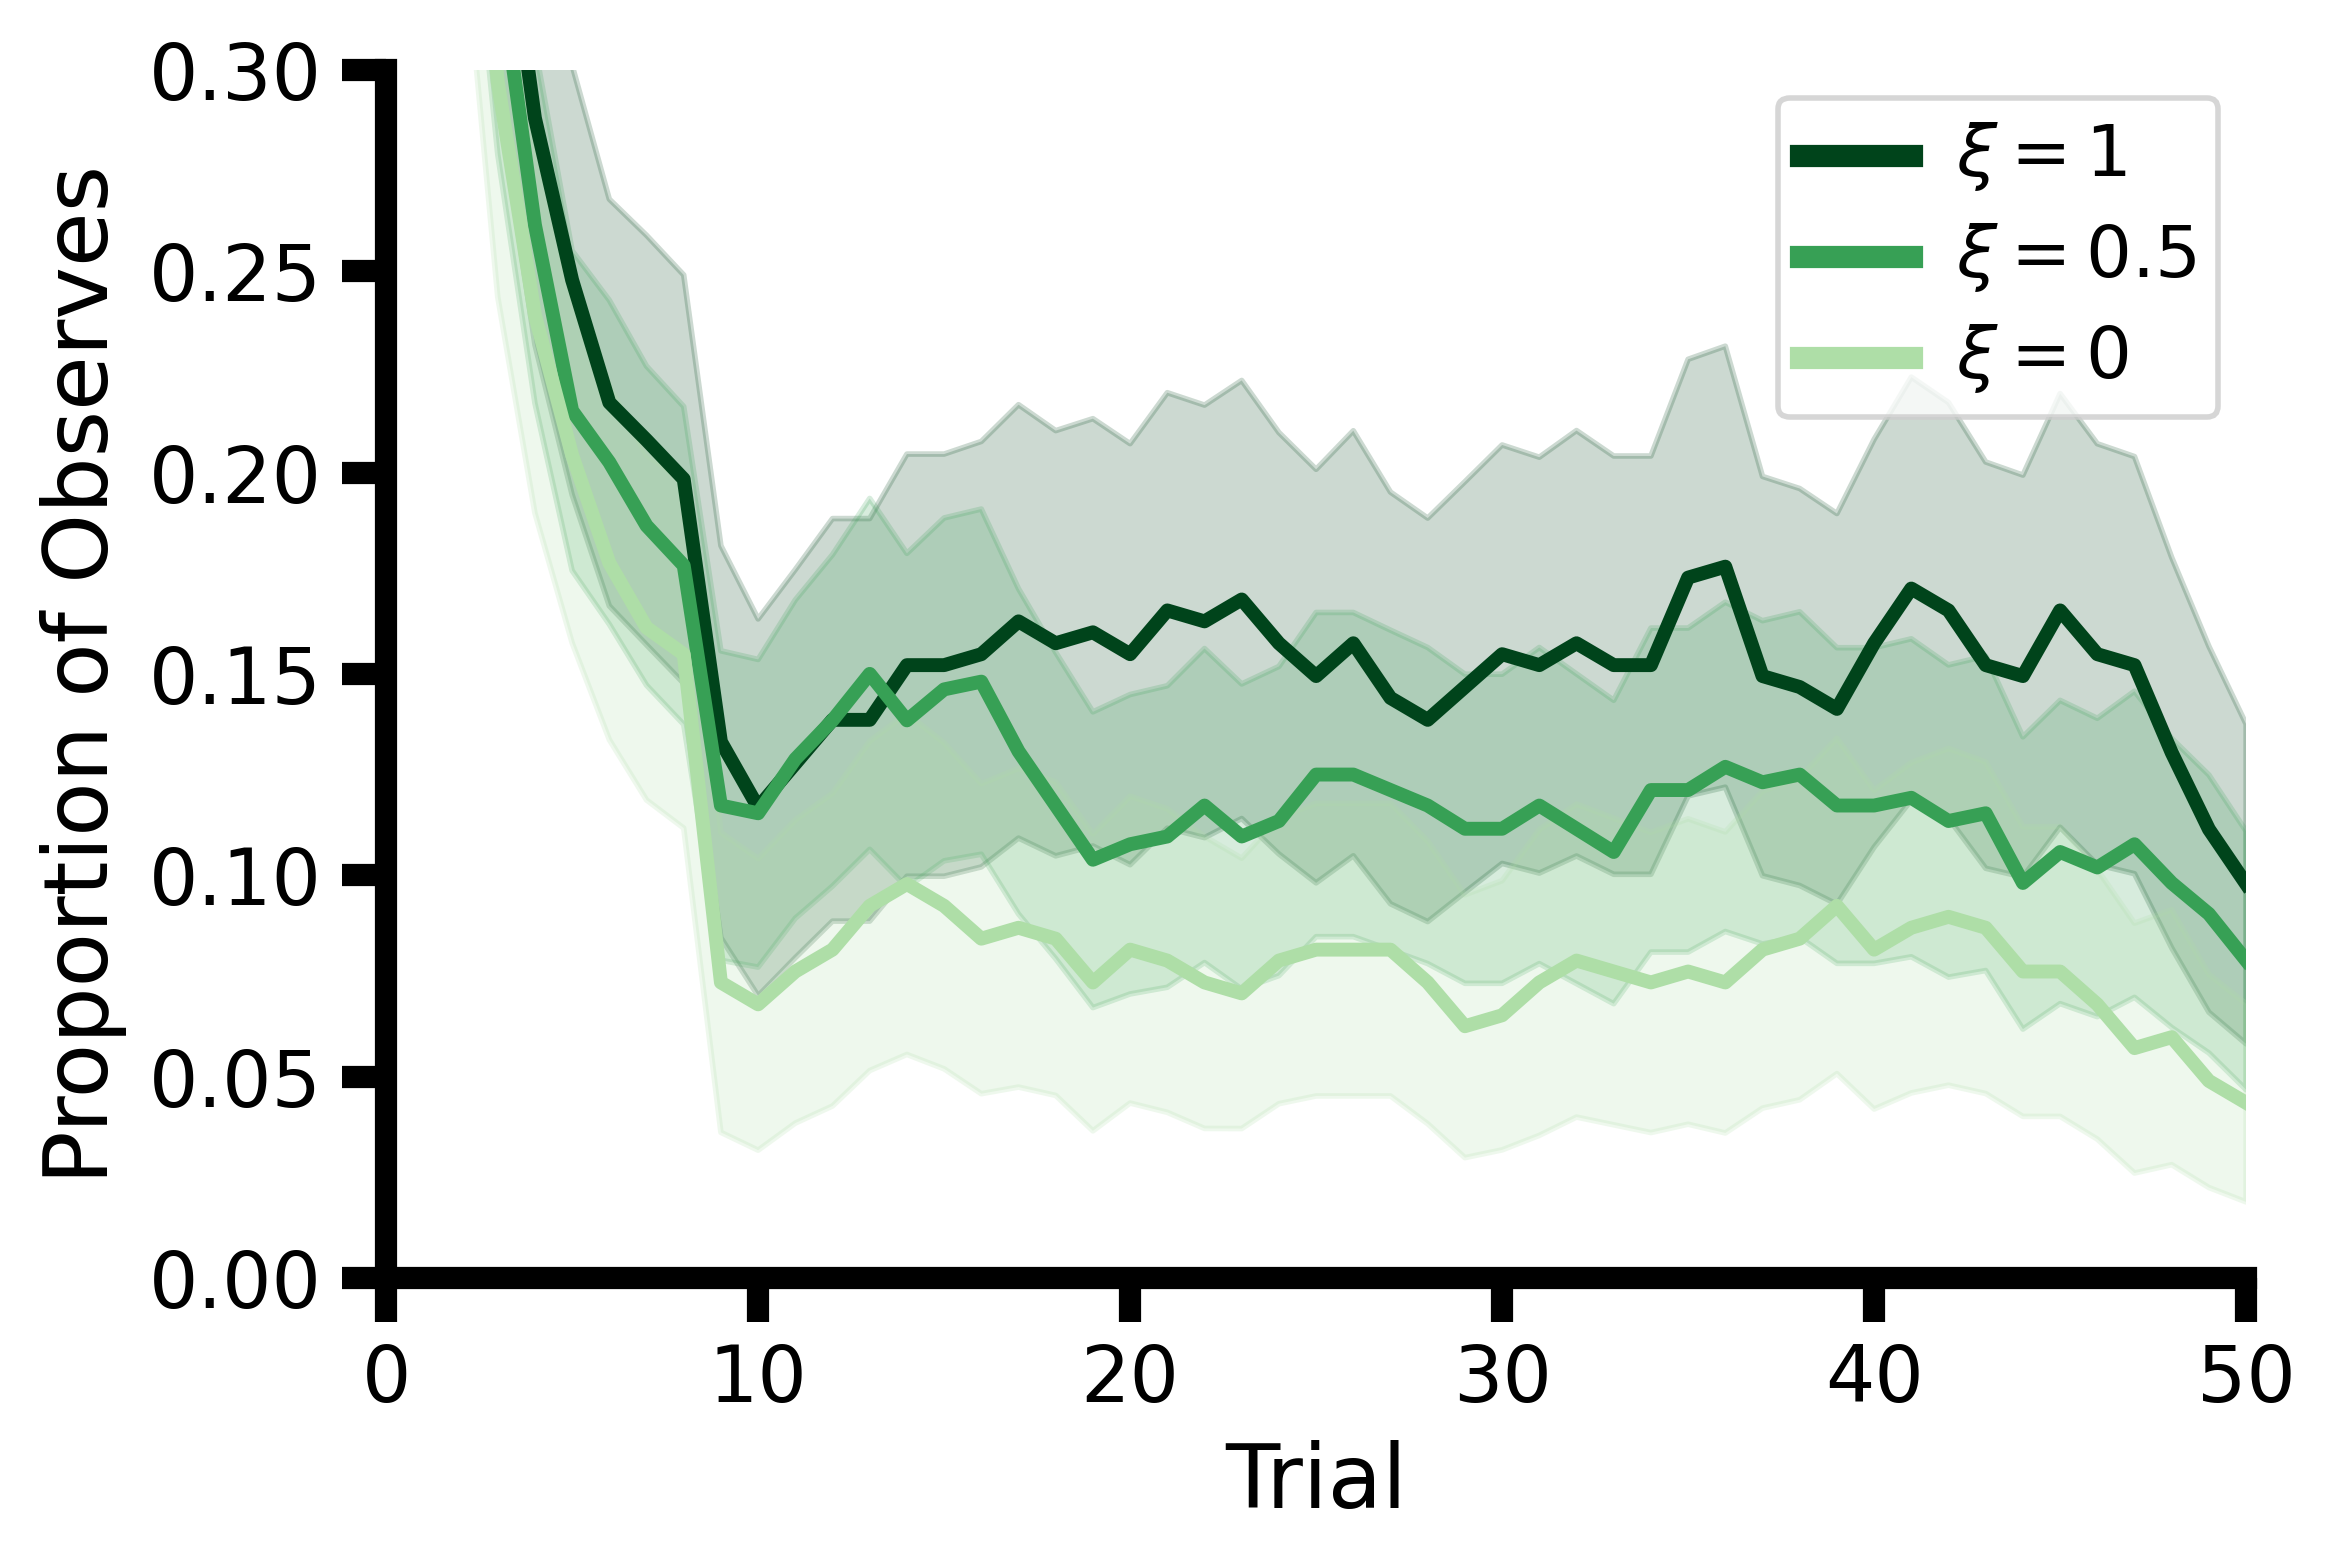

In [5]:
mean_peek_probs = np.array([observation.mean(axis=0) for observation in observations])
stderr_peek_probs = np.array([observation.std(axis=0)/np.sqrt(observation.shape[0]) for observation in observations])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_peek_probs = pd.DataFrame(mean_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_peek_probs = pd.DataFrame(stderr_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = np.arange(1, mean_peek_probs.shape[1]+1)

for i in range(len(mean_peek_probs)):
    # ax.plot(steps, mean_peek_probs[i], label=1-taus[i], color='C%d' %i)
    #ax.plot(steps, mean_peek_probs[i], label=effs_to_plot[i], color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)))
    ax.plot(steps, mean_peek_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)))
    ax.fill_between(steps, mean_peek_probs[i] - stderr_peek_probs[i], mean_peek_probs[i] + stderr_peek_probs[i], color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)), alpha=0.2)

#ax.bar(range(len(policy)))

#ax.legend(title=r"$\xi$")
ax.legend()

ax.set_xlabel("Trial")
ax.set_ylabel("Proportion of Observes")
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if ylim is not None:
    ax.set_ylim(ylim)

ax.set_xlim(0, n_steps)

format_axis(ax)

In [6]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.svg'))

#### Stats

In [7]:
cropped_observations = [observation[:,15:].mean(axis=1) for observation in observations]
plotted_levels = [1, 0.5, 0]

In [8]:
## MEANS AND SEMS
print("Overall N", len(df))

for level, obs in zip(plotted_levels, cropped_observations):
    print("Test Controllability ", level)
    print("Mean ", obs.mean())
    print("StdErr ", obs.std()/np.sqrt(obs.shape[0]))
    print("N", obs.shape[0])

Overall N 111
Test Controllability  1
Mean  0.1440993788819876
StdErr  0.011978290153677802
N 46
Test Controllability  0.5
Mean  0.1068131868131868
StdErr  0.00961576861930955
N 65
Test Controllability  0
Mean  0.0701863354037267
StdErr  0.01120447733215002
N 46


In [9]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_observations)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_observations), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   0.0    0.5   0.0366 0.0451 0.0006 0.0726   True
   0.0    1.0   0.0739    0.0  0.035 0.1129   True
   0.5    1.0   0.0373 0.0405 0.0013 0.0733   True
--------------------------------------------------


In [10]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_observes')
glm.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  n_observes
No. Observations:    999      Method:              REML      
No. Groups:          111      Scale:               5.9663    
Min. group size:     9        Log-Likelihood:      -2459.7416
Max. group size:     9        Converged:           Yes       
Mean group size:     9.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           5.082    0.484 10.506 0.000  4.134  6.031
C(group_C)[T.True] -0.319    0.613 -0.521 0.603 -1.519  0.882
efficacy            2.777    0.239 11.598 0.000  2.308  3.246
Group Var           9.443    0.594                           
=============================================================

"""

### APE-trained neural networks

In [11]:
from settings_ana import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_ana import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

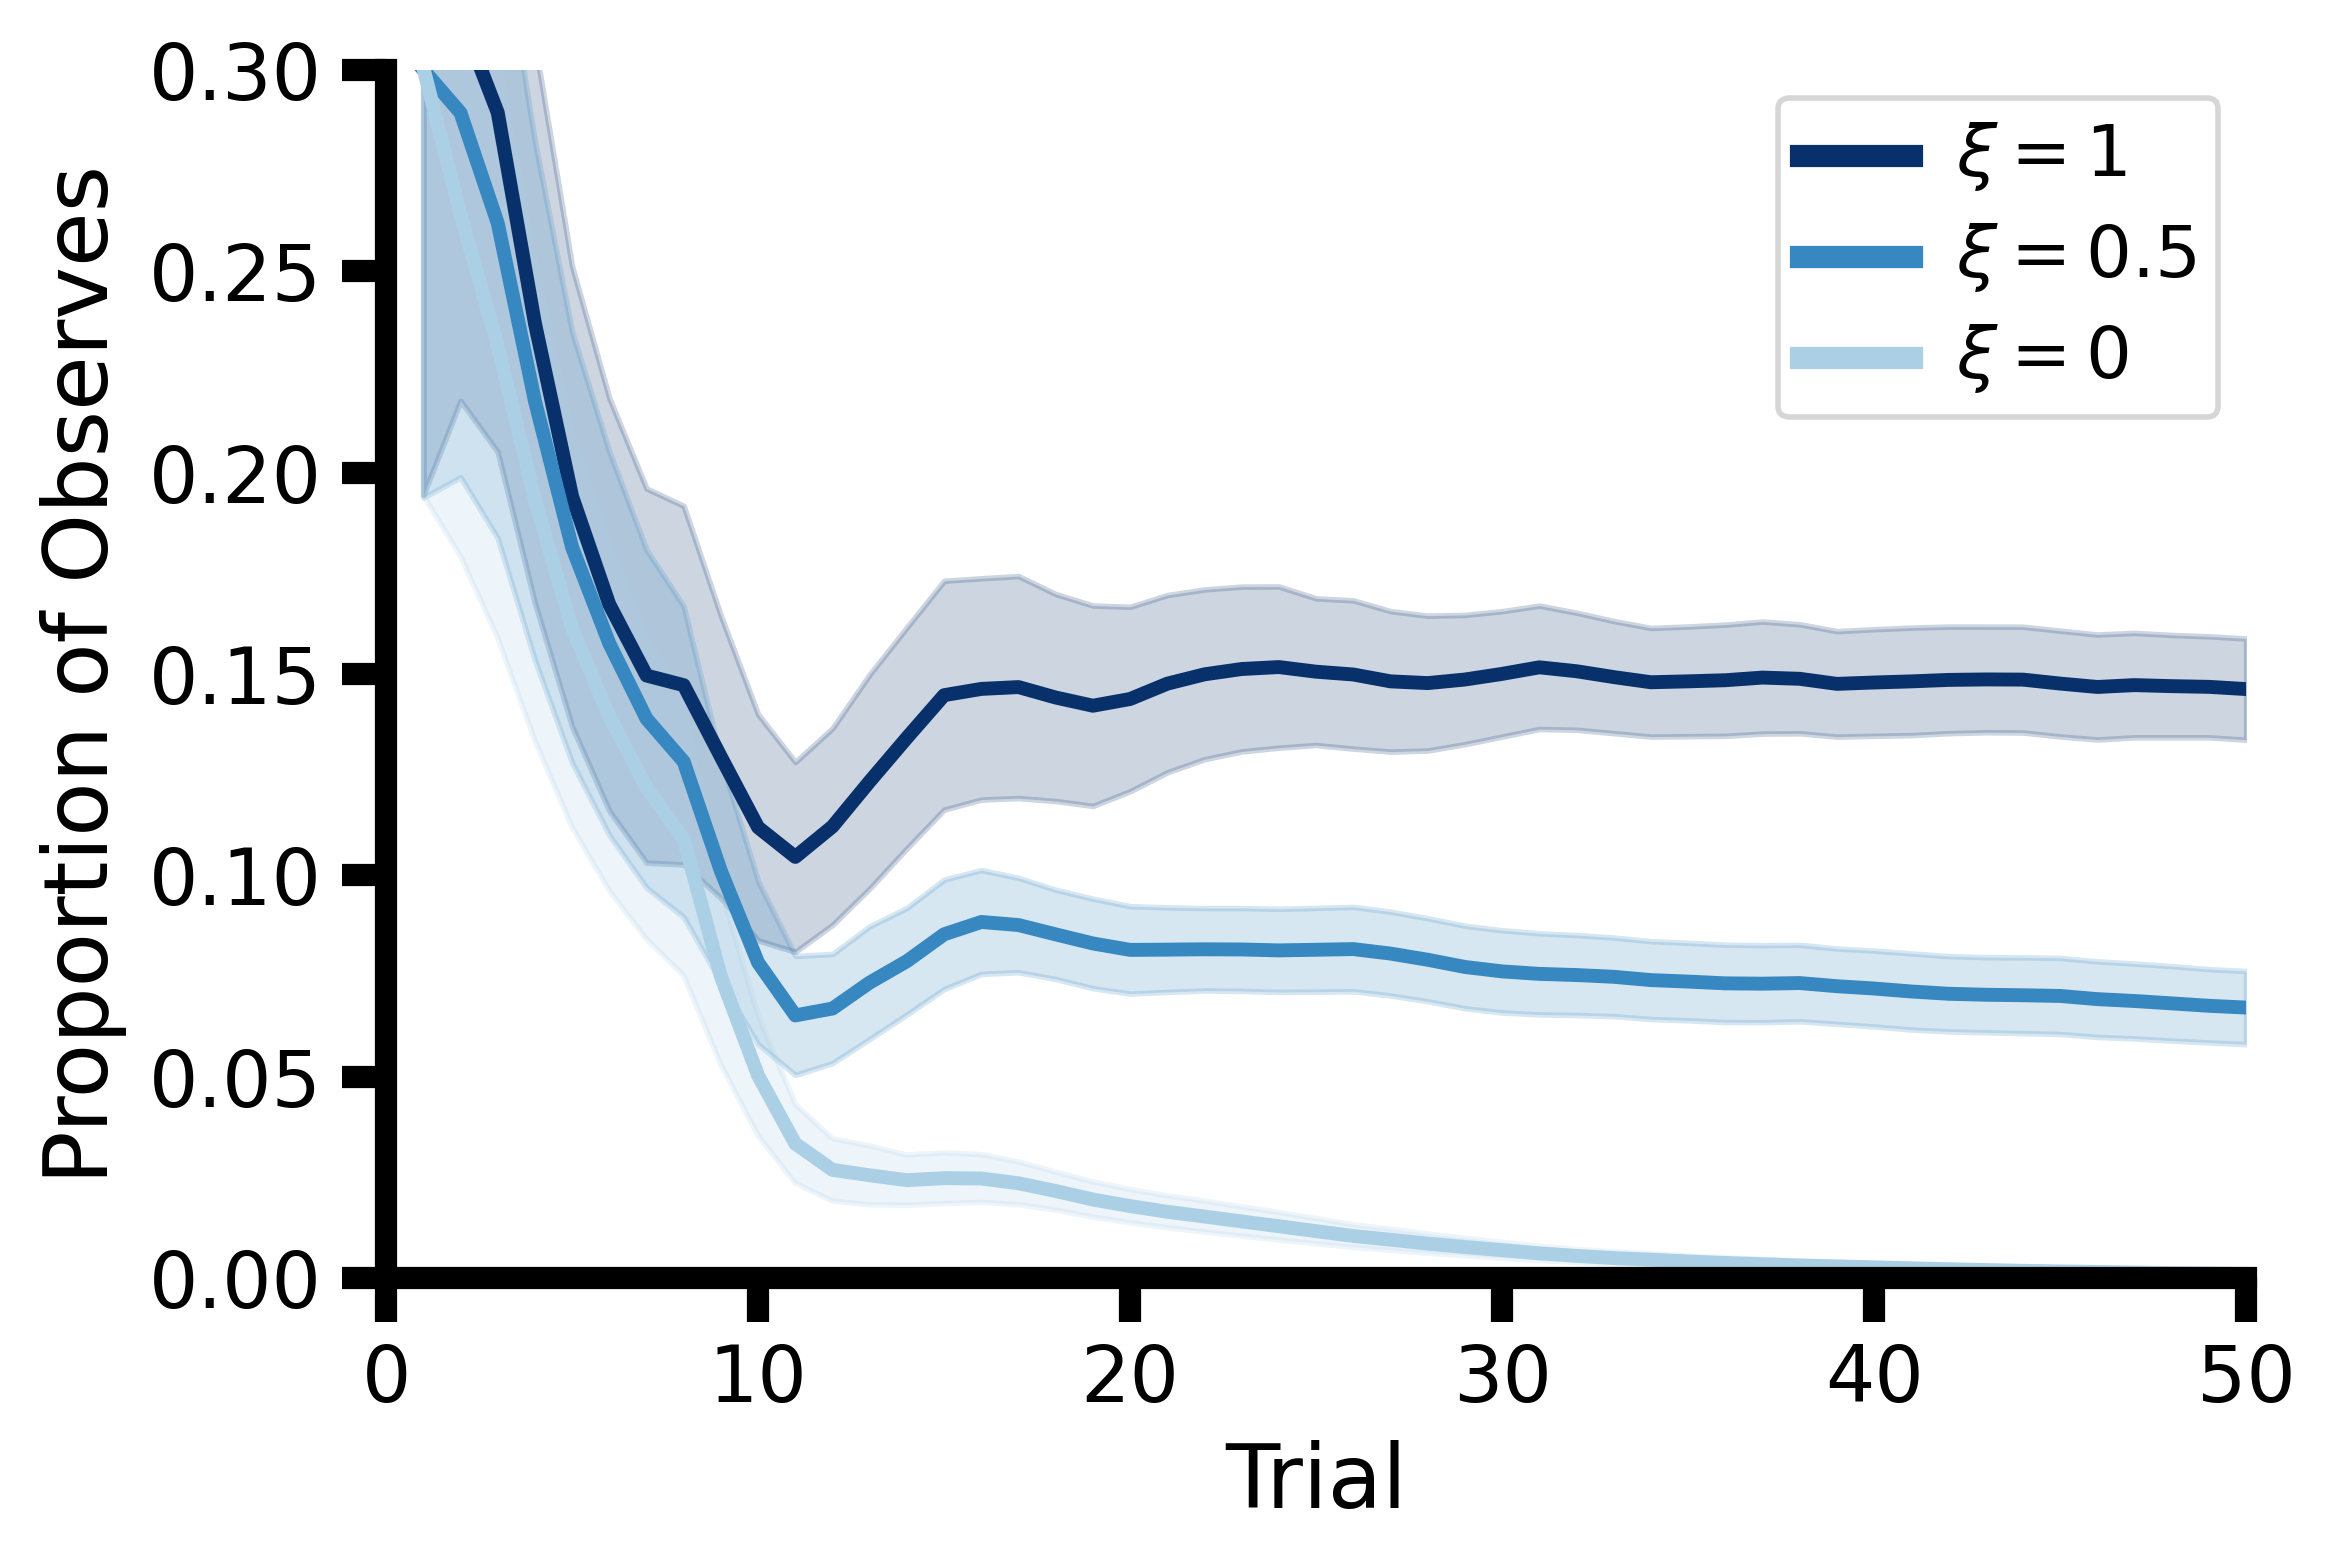

In [12]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Proportion of Observes")

In [13]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_apes.svg'))

### No-APE Networks

In [14]:
from settings_ana import pepe_human_control_models as control_models
from settings_ana import pepe_human_control_traj_timestamp as traj_timestamp
from utils_project import load_modelrun_files

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

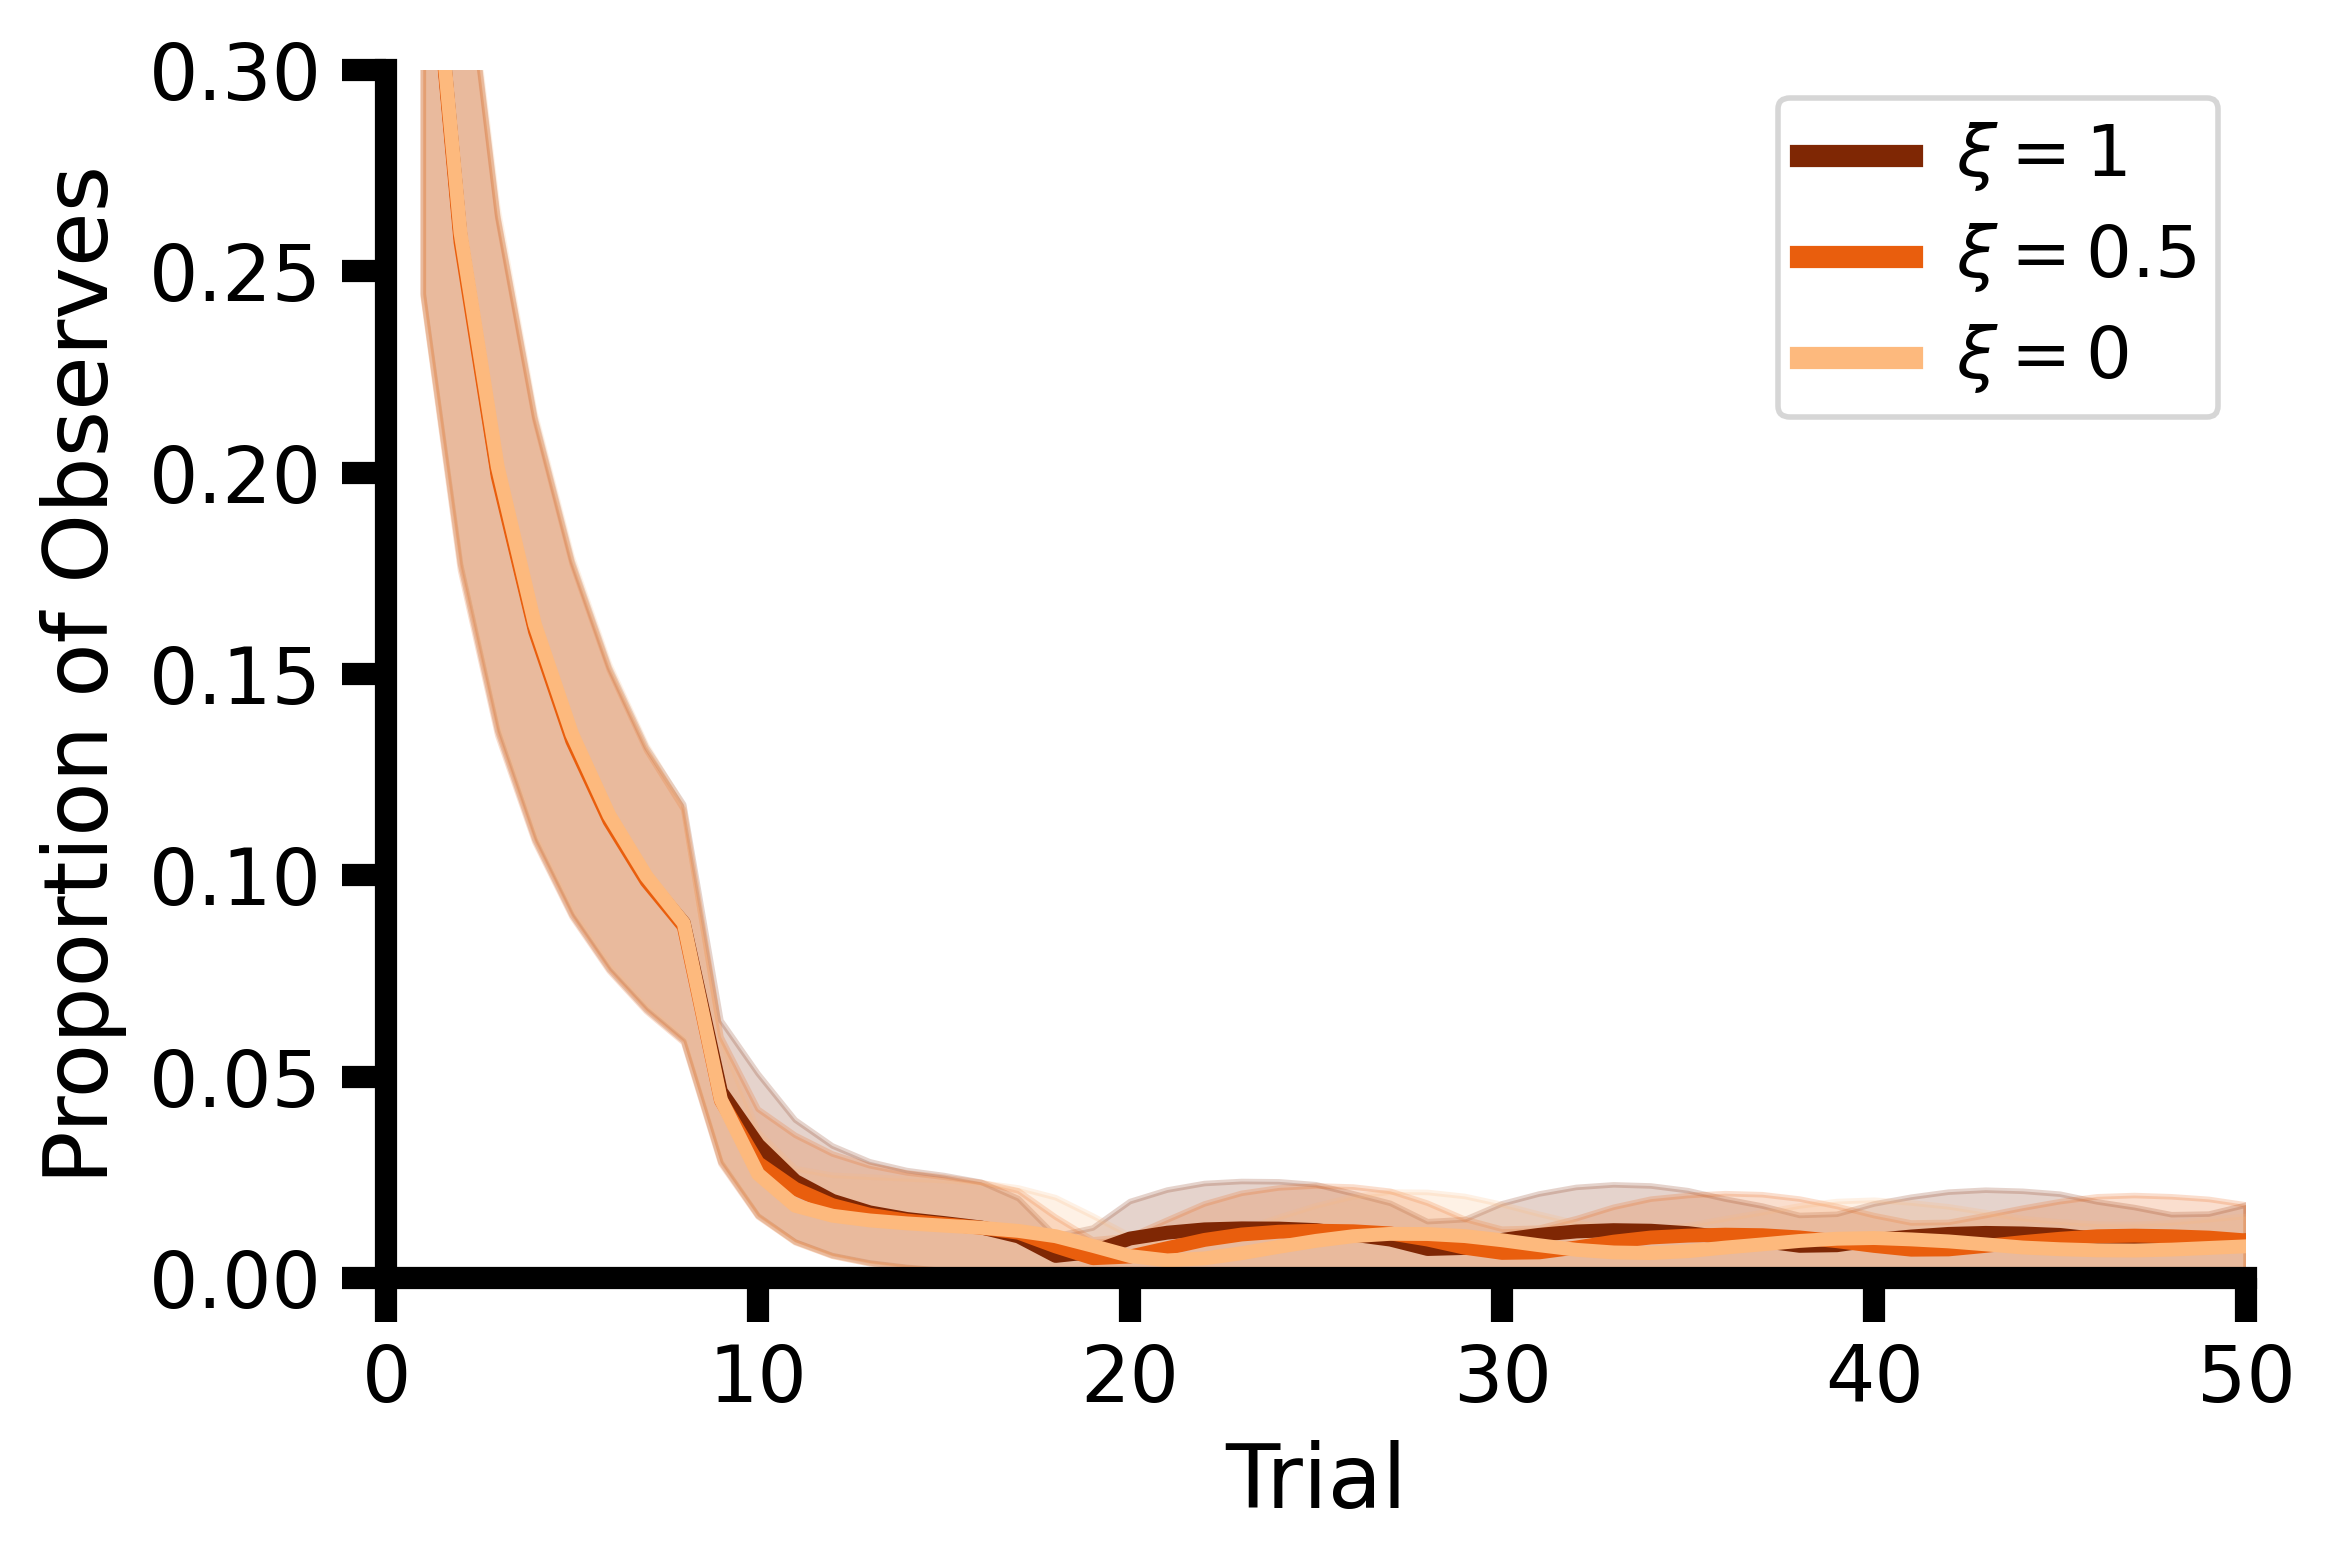

In [15]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Proportion of Observes")

In [16]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.svg'))

## Panel B: Single-Episode Rewards
### General Options

In [17]:
ylim = (0.1, 0.9)
smoothing_window = 8

### Humans

In [18]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [19]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start, group = df['group'])
correct_takes = transitions_test
correct_takes = [correct_takes[0][:,3], correct_takes[1][:,2], correct_takes[0][:,0]] ## plotting highest efficacy first

## convert observations to np.nans
for correct_take in correct_takes:
    correct_take[correct_take == 0.5] = np.nan

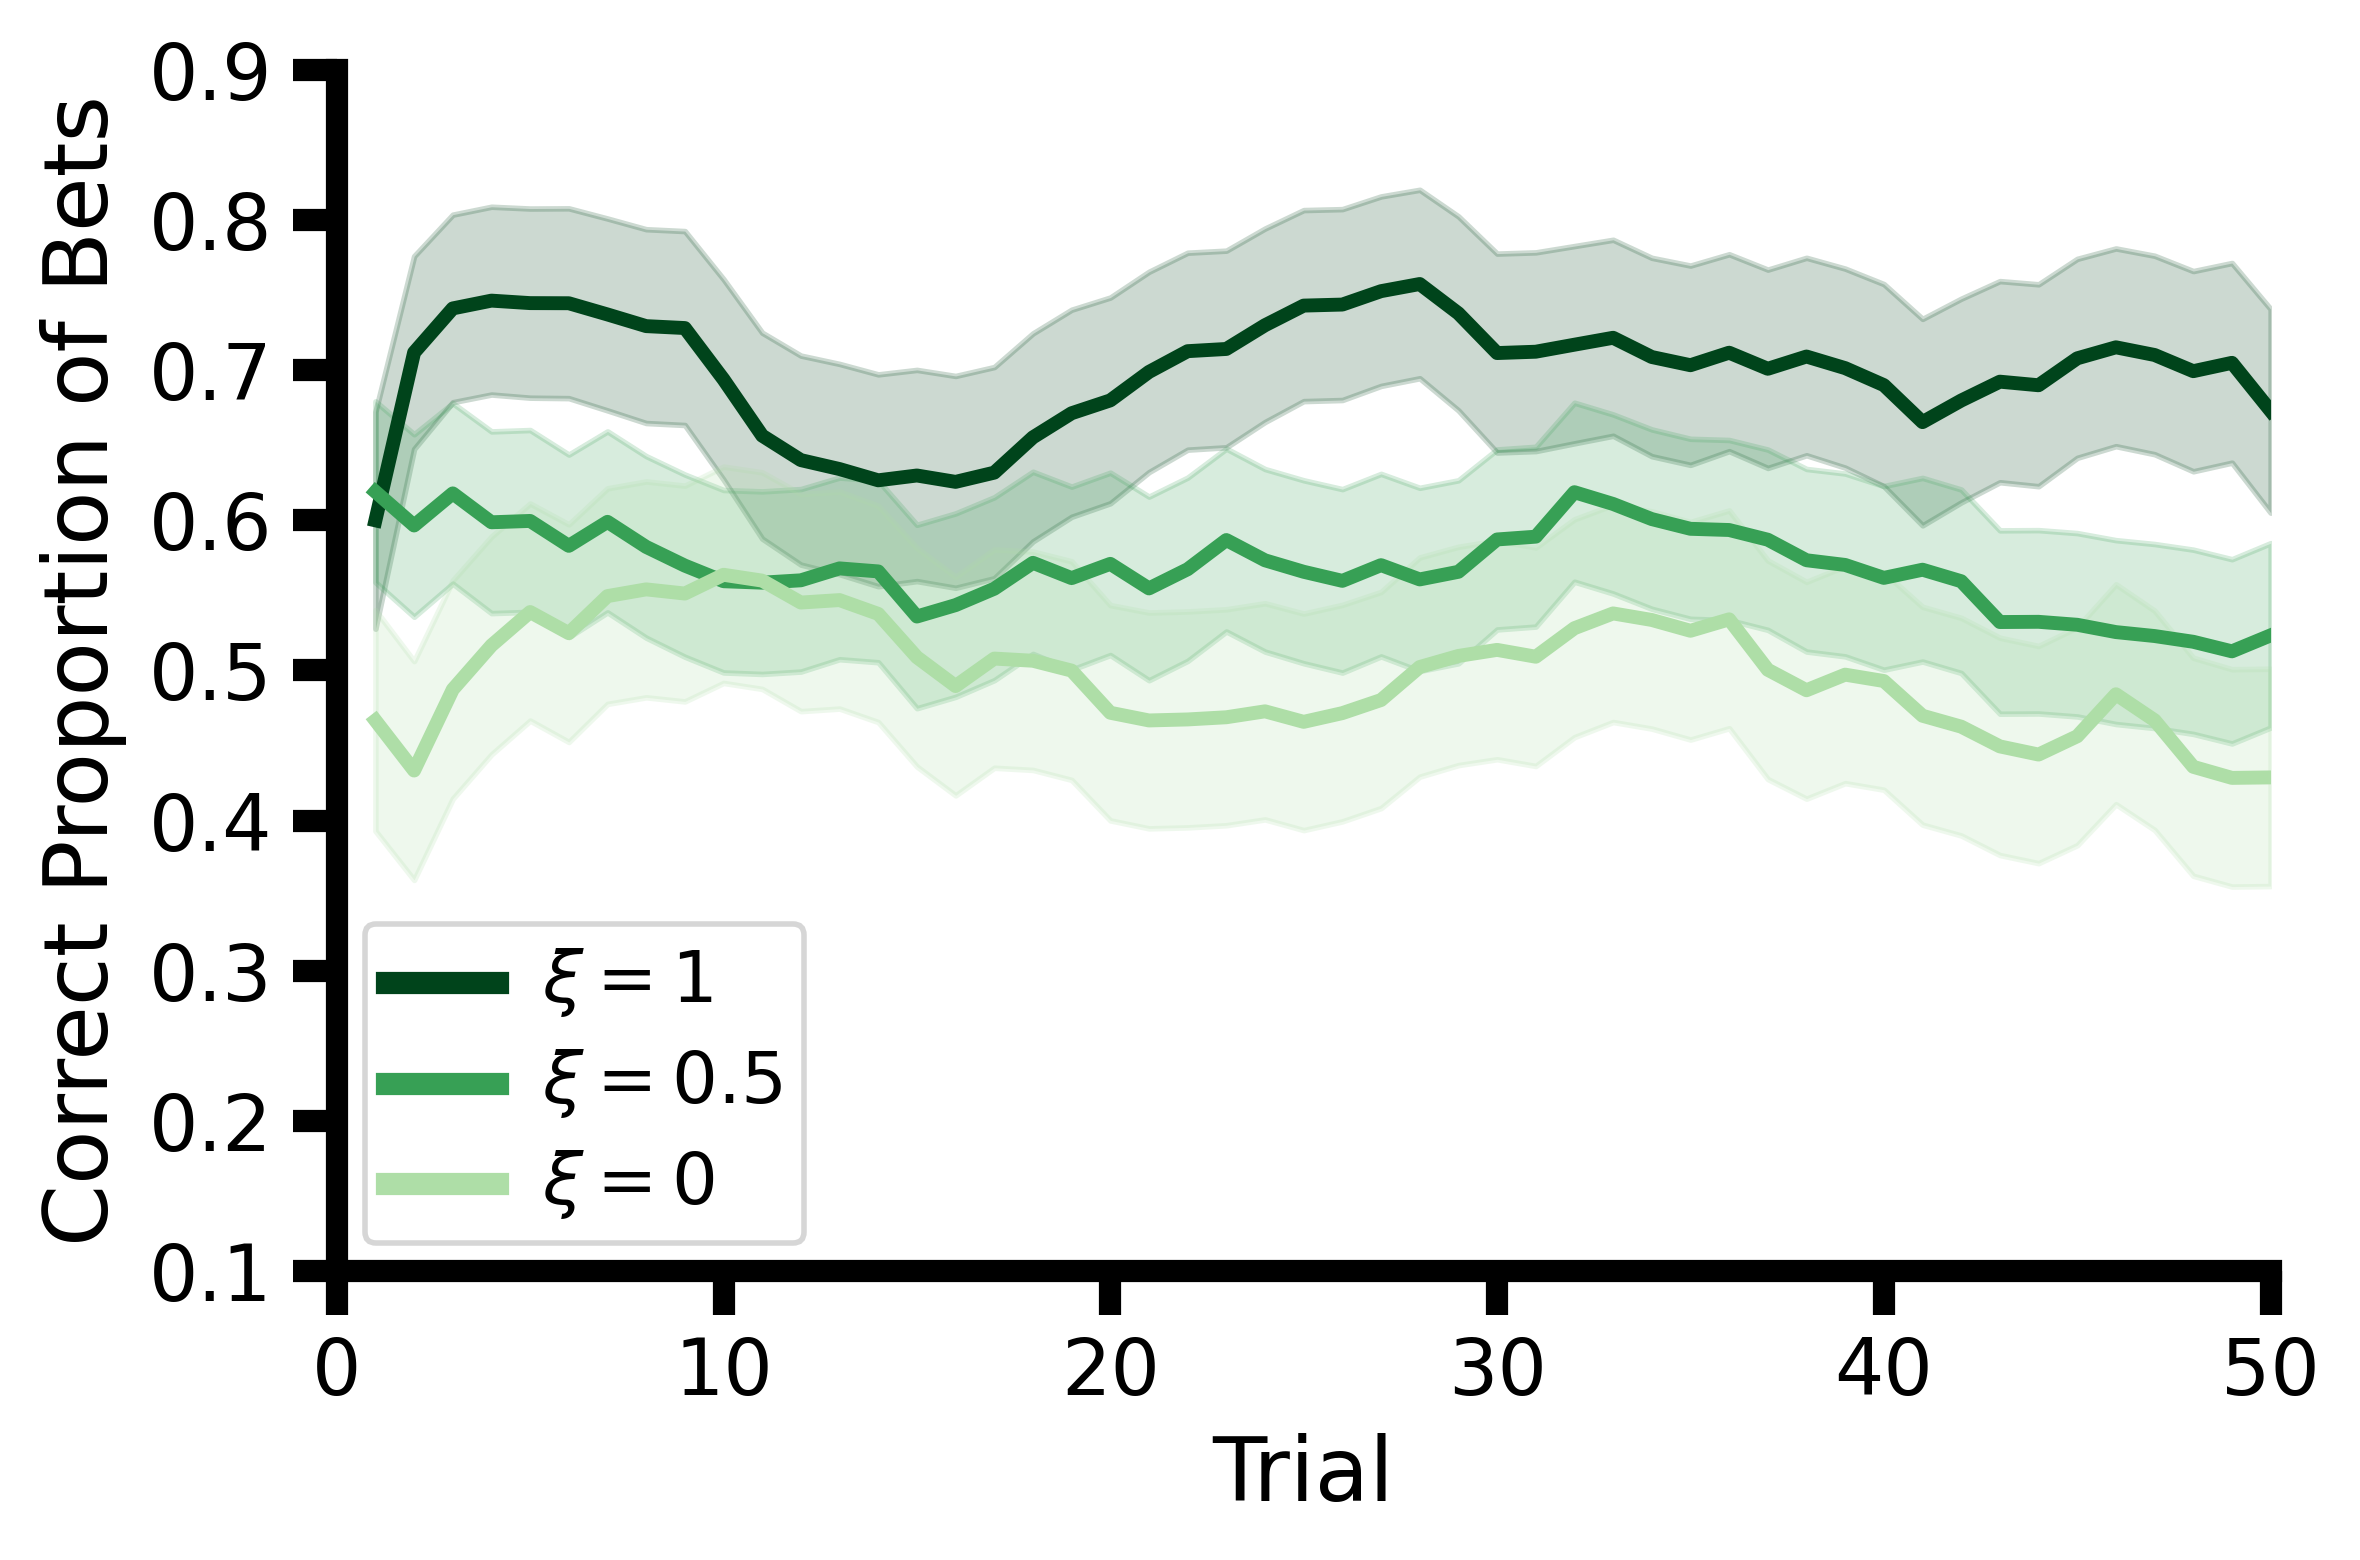

In [20]:
mean_probs = np.array([np.nanmean(correct_take, axis=0) for correct_take in correct_takes])
stderr_probs = np.array([np.nanstd(correct_take, axis=0)/np.sqrt(correct_take.shape[0]) for correct_take in correct_takes])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_probs = pd.DataFrame(mean_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_probs = pd.DataFrame(stderr_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = np.arange(1, mean_probs.shape[1]+1)

for i in range(len(mean_probs)):
    #print(mean_probs[i])
    # ax.plot(steps, mean_peek_probs[i], label=1-taus[i], color='C%d' %i)
    #ax.plot(steps, mean_probs[i], label=effs_to_plot[i], color=cmap_humans((len(mean_probs) - i)/len(mean_probs)))
    ax.plot(steps, mean_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_probs) - i)/len(mean_probs)))
    ax.fill_between(steps, mean_probs[i] - stderr_probs[i], mean_probs[i] + stderr_probs[i], color=cmap_humans((len(mean_probs) - i)/len(mean_probs)), alpha=0.2)

#ax.bar(range(len(policy)))

#ax.legend(title="Efficacy")
ax.legend()

#ax.set_xlabel("Steps")
ax.set_xlabel("Trial")
ax.set_ylabel("Correct Proportion of Bets")
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if ylim is not None:
    ax.set_ylim(ylim)

ax.set_xlim(0, n_steps)

format_axis(ax)

plt.tight_layout()


In [21]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.svg'))

#### Stats

In [22]:
cropped_takes = [np.nanmean(take[:,15:], axis=1) for take in correct_takes]
plotted_levels = [1, 0.5, 0]

In [23]:
## MEANS AND SEMS
for level, takes in zip(plotted_levels, cropped_takes):
    print("Test Controllability ", level)
    print("Mean ", np.nanmean(takes))
    print("StdErr ", np.nanstd(takes)/np.sqrt(len(takes)))
    print("N" , len(takes))

Test Controllability  1
Mean  0.7078379106638373
StdErr  0.02784494161865188
N 46
Test Controllability  0.5
Mean  0.5664165619858597
StdErr  0.015941210054804613
N 65
Test Controllability  0
Mean  0.478480613862632
StdErr  0.012400078710872134
N 46


In [24]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_takes)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_takes), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    0.5   0.0879 0.004 0.0239  0.152   True
   0.0    1.0   0.2294   0.0   0.16 0.2987   True
   0.5    1.0   0.1414   0.0 0.0774 0.2055   True
-------------------------------------------------


In [25]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_observes')
glm.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  n_observes
No. Observations:    999      Method:              REML      
No. Groups:          111      Scale:               5.9663    
Min. group size:     9        Log-Likelihood:      -2459.7416
Max. group size:     9        Converged:           Yes       
Mean group size:     9.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           5.082    0.484 10.506 0.000  4.134  6.031
C(group_C)[T.True] -0.319    0.613 -0.521 0.603 -1.519  0.882
efficacy            2.777    0.239 11.598 0.000  2.308  3.246
Group Var           9.443    0.594                           
=============================================================

"""

### APE-trained Neural Networks

In [26]:
from settings_ana import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_ana import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

trajss_ps_taus_ape = np.array(trajss_ps_taus_ape)
trajss_ps_taus_ape = trajss_ps_taus_ape[:, ::4]

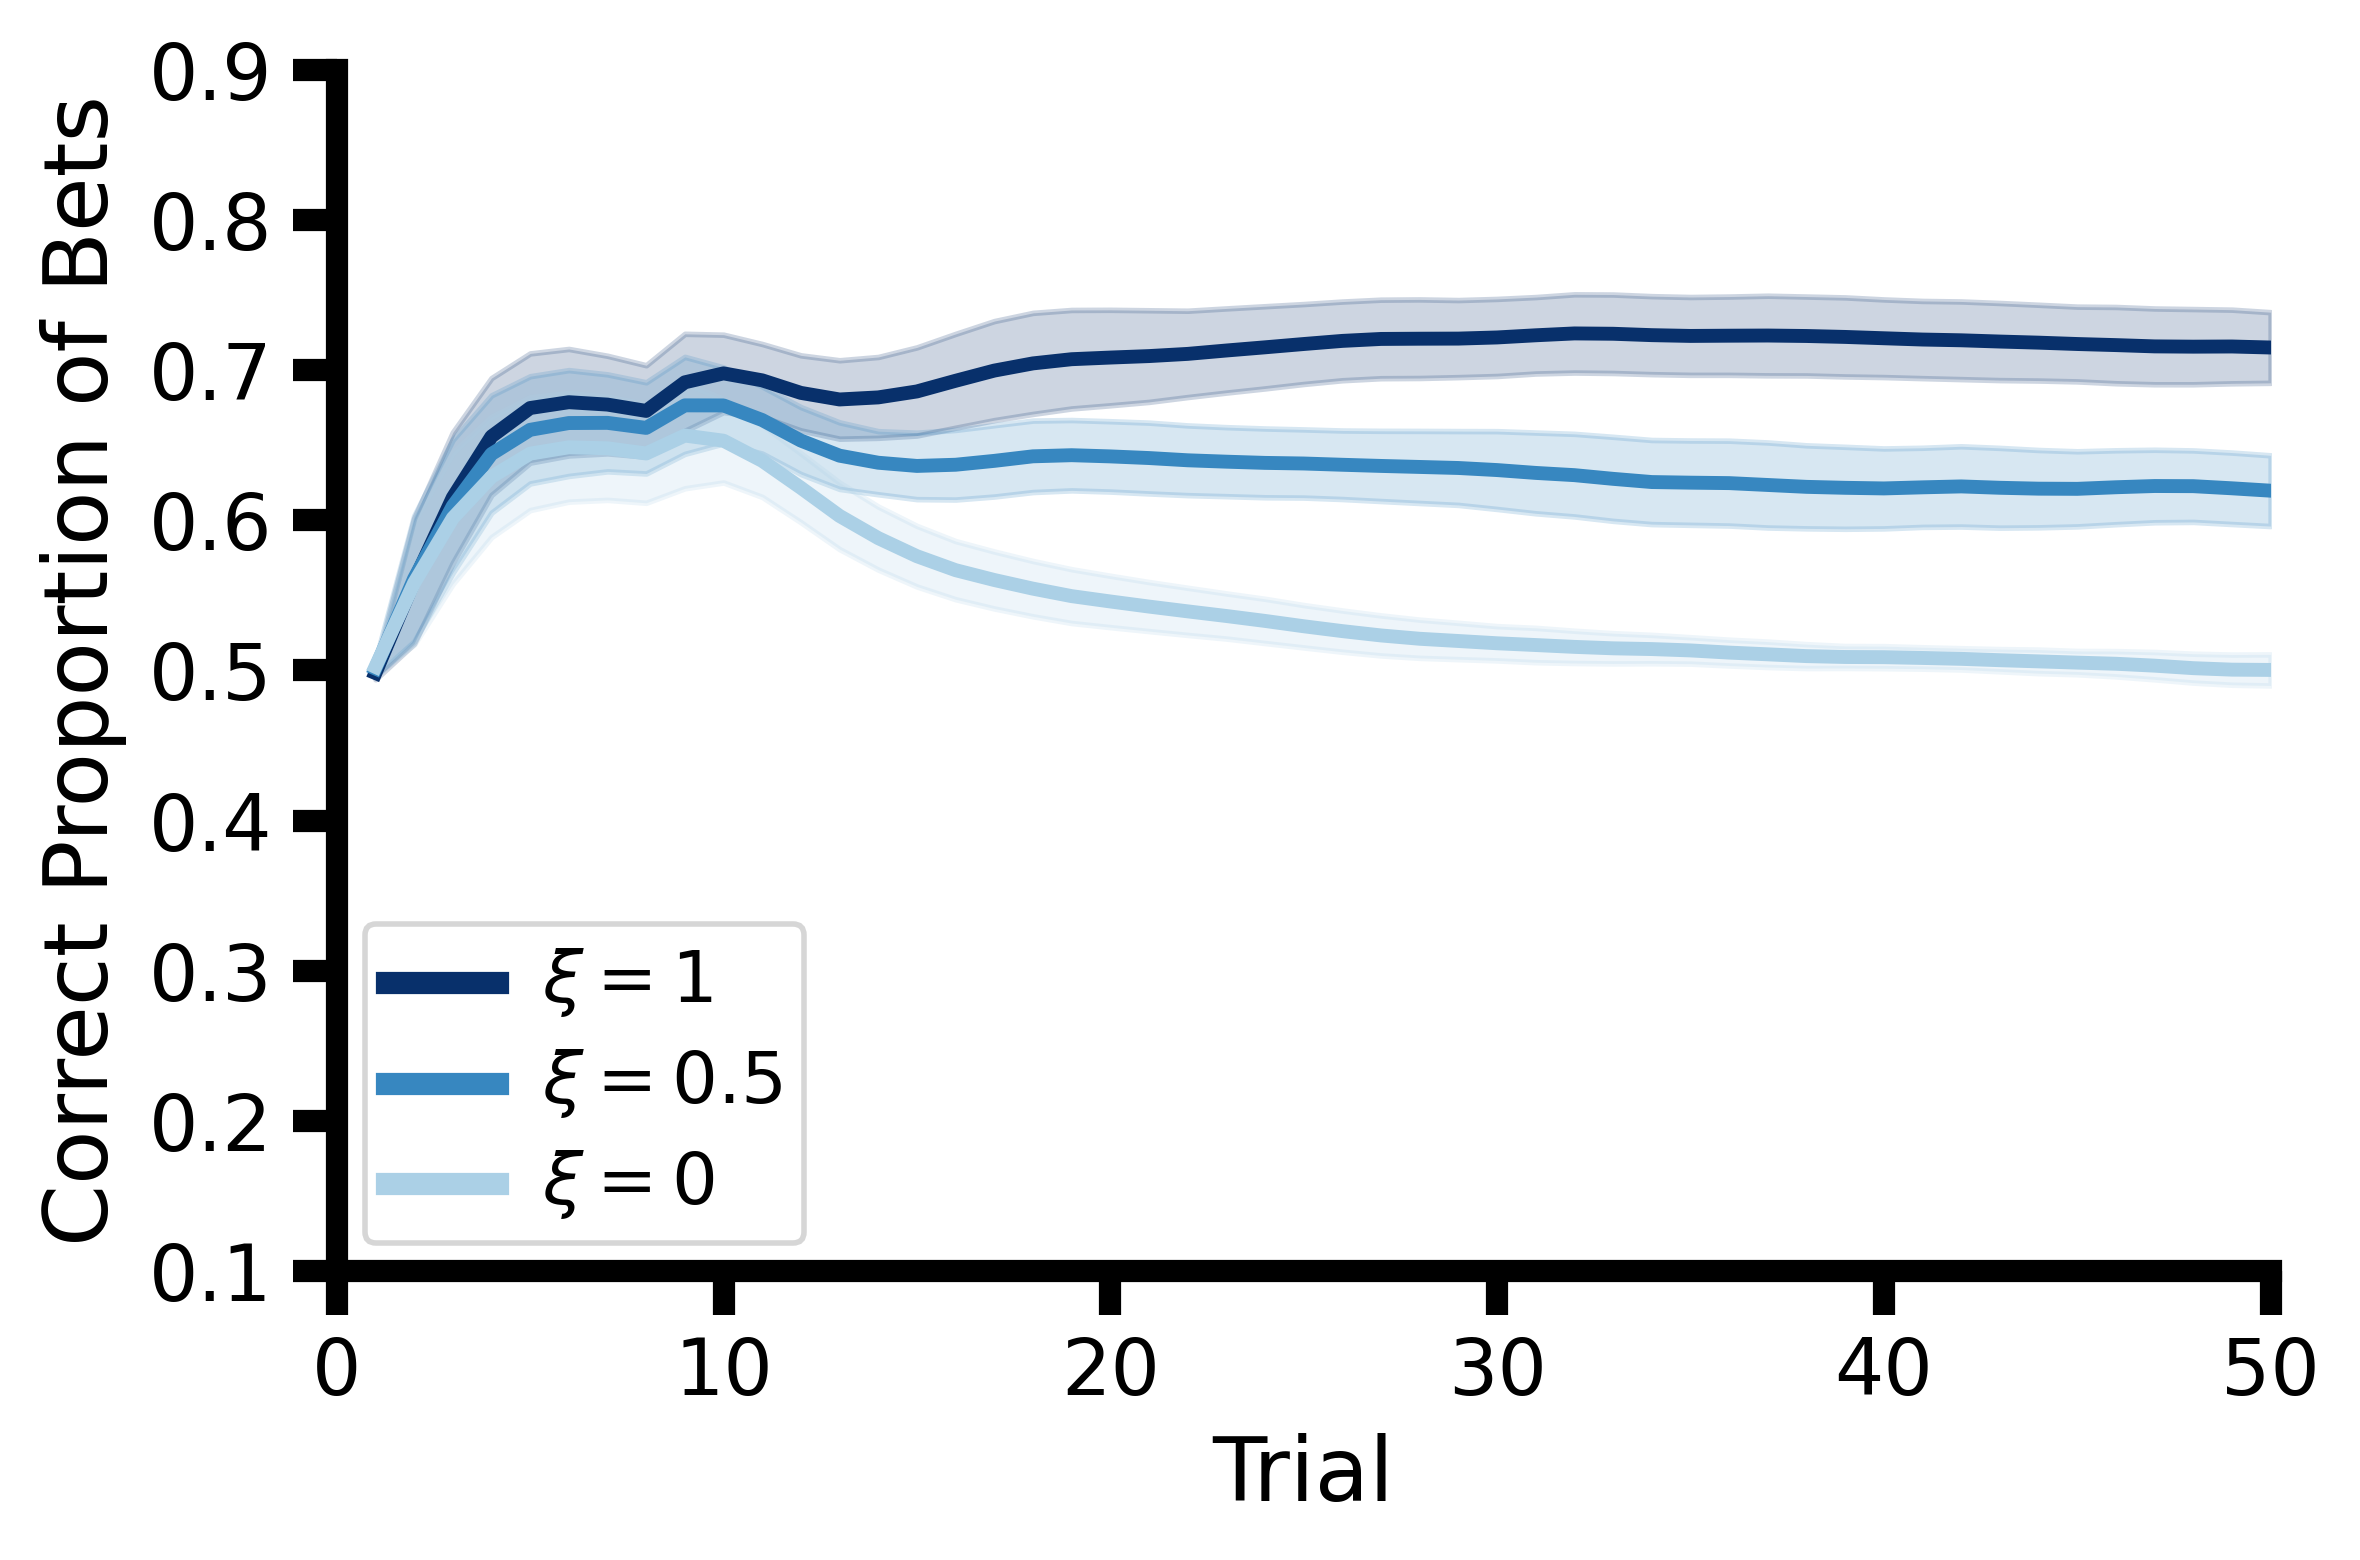

In [27]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, trajss_ps_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Correct Proportion of Bets")

In [28]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.svg'))

### No-APE Networks

In [29]:
from settings_ana import pepe_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_ana import pepe_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

trajss_ps_taus_control = np.array(trajss_ps_taus_control)
trajss_ps_taus_control = trajss_ps_taus_control[:, ::4]

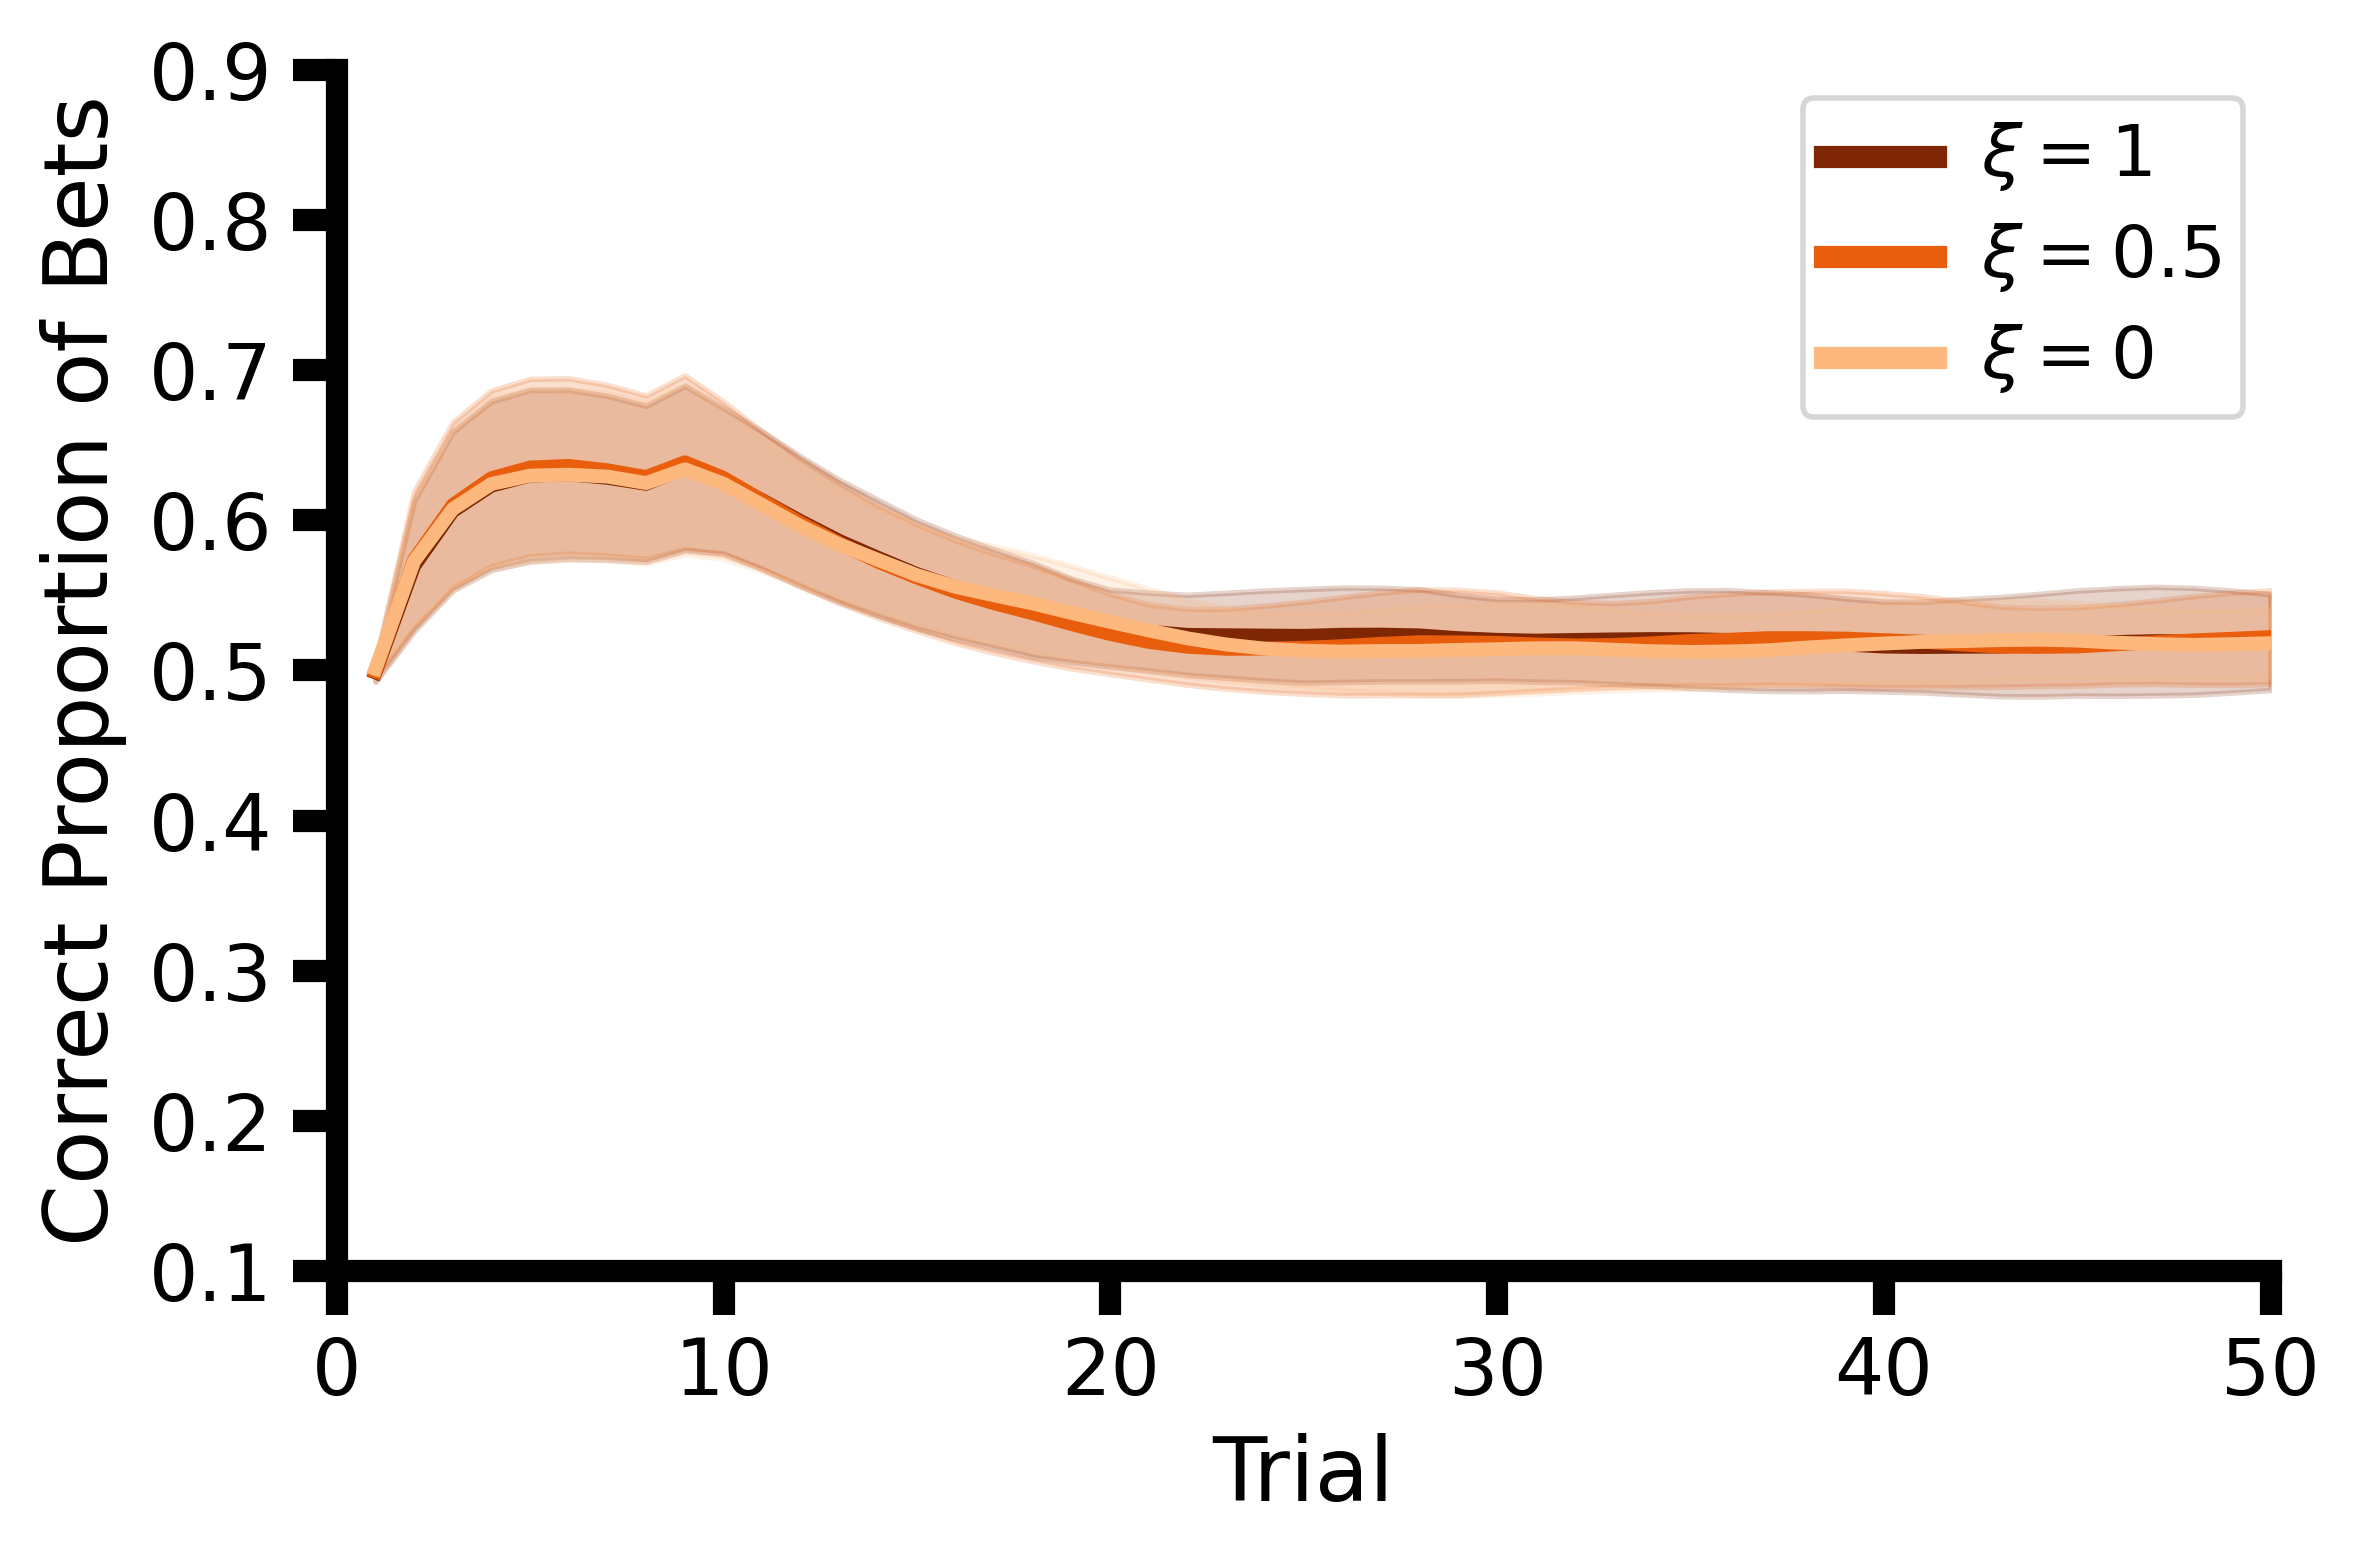

In [30]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_control, trajss_ps_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Correct Proportion of Bets")

In [31]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noape.svg'))

## Panel C: Across-Efficacy Observations
### General Options

In [32]:
ylim = (-1.25,25.5)

### Humans

In [33]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [34]:
n_trainA, n_testA = sort_train_test(df[~df['group']]['n_observes'], df[~df['group']]['effs'], test_start[0])
n_trainB, n_testB = sort_train_test(df[df['group']]['n_observes'], df[df['group']]['effs'], test_start[1])


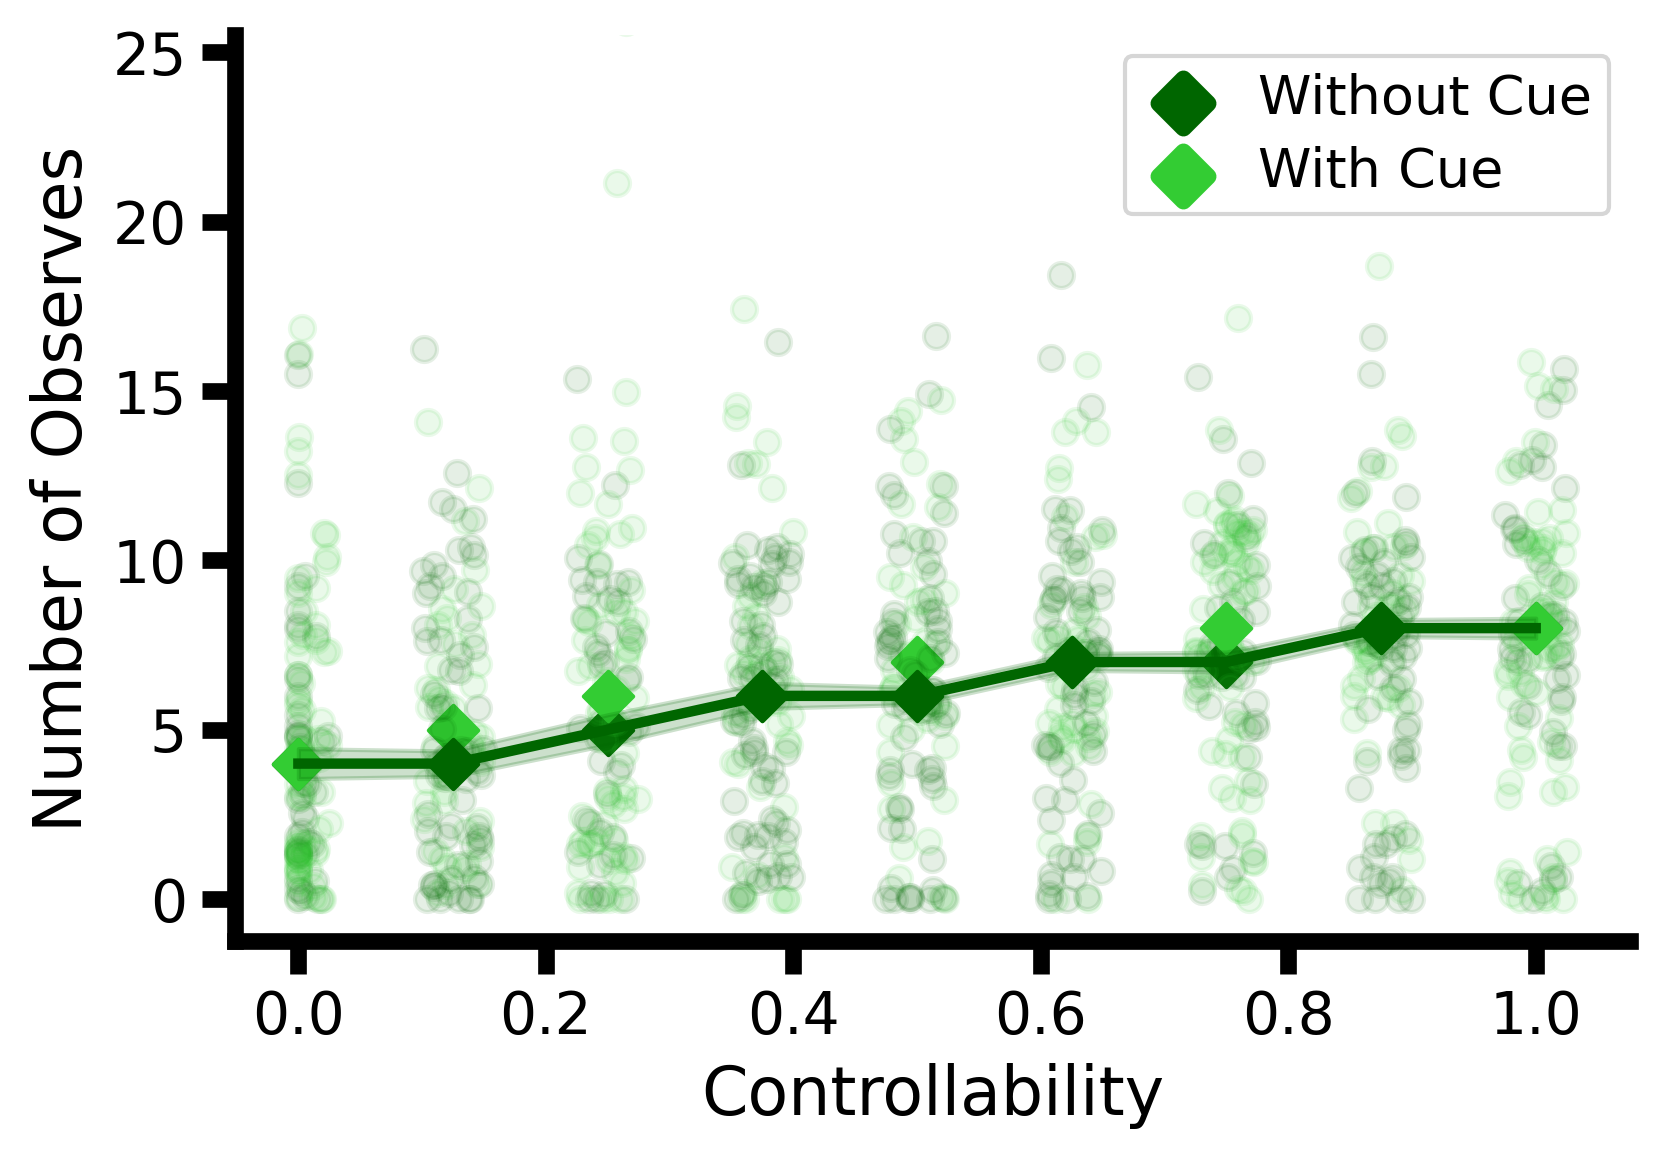

In [35]:
from human_plot_traj_analyses import plot_line_scatter_group
    
fig = plot_line_scatter_group((n_testA, n_testB), effs_test, (n_trainA, n_trainB), effs_train, ylabel='Number of Observes', xjitter=0.025, yjitter=1, median_over_mean=True, ylim=ylim, xlabel="Controllability")

In [36]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.svg'))

### APE-trained neural networks

In [37]:
from settings_ana import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_ana import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

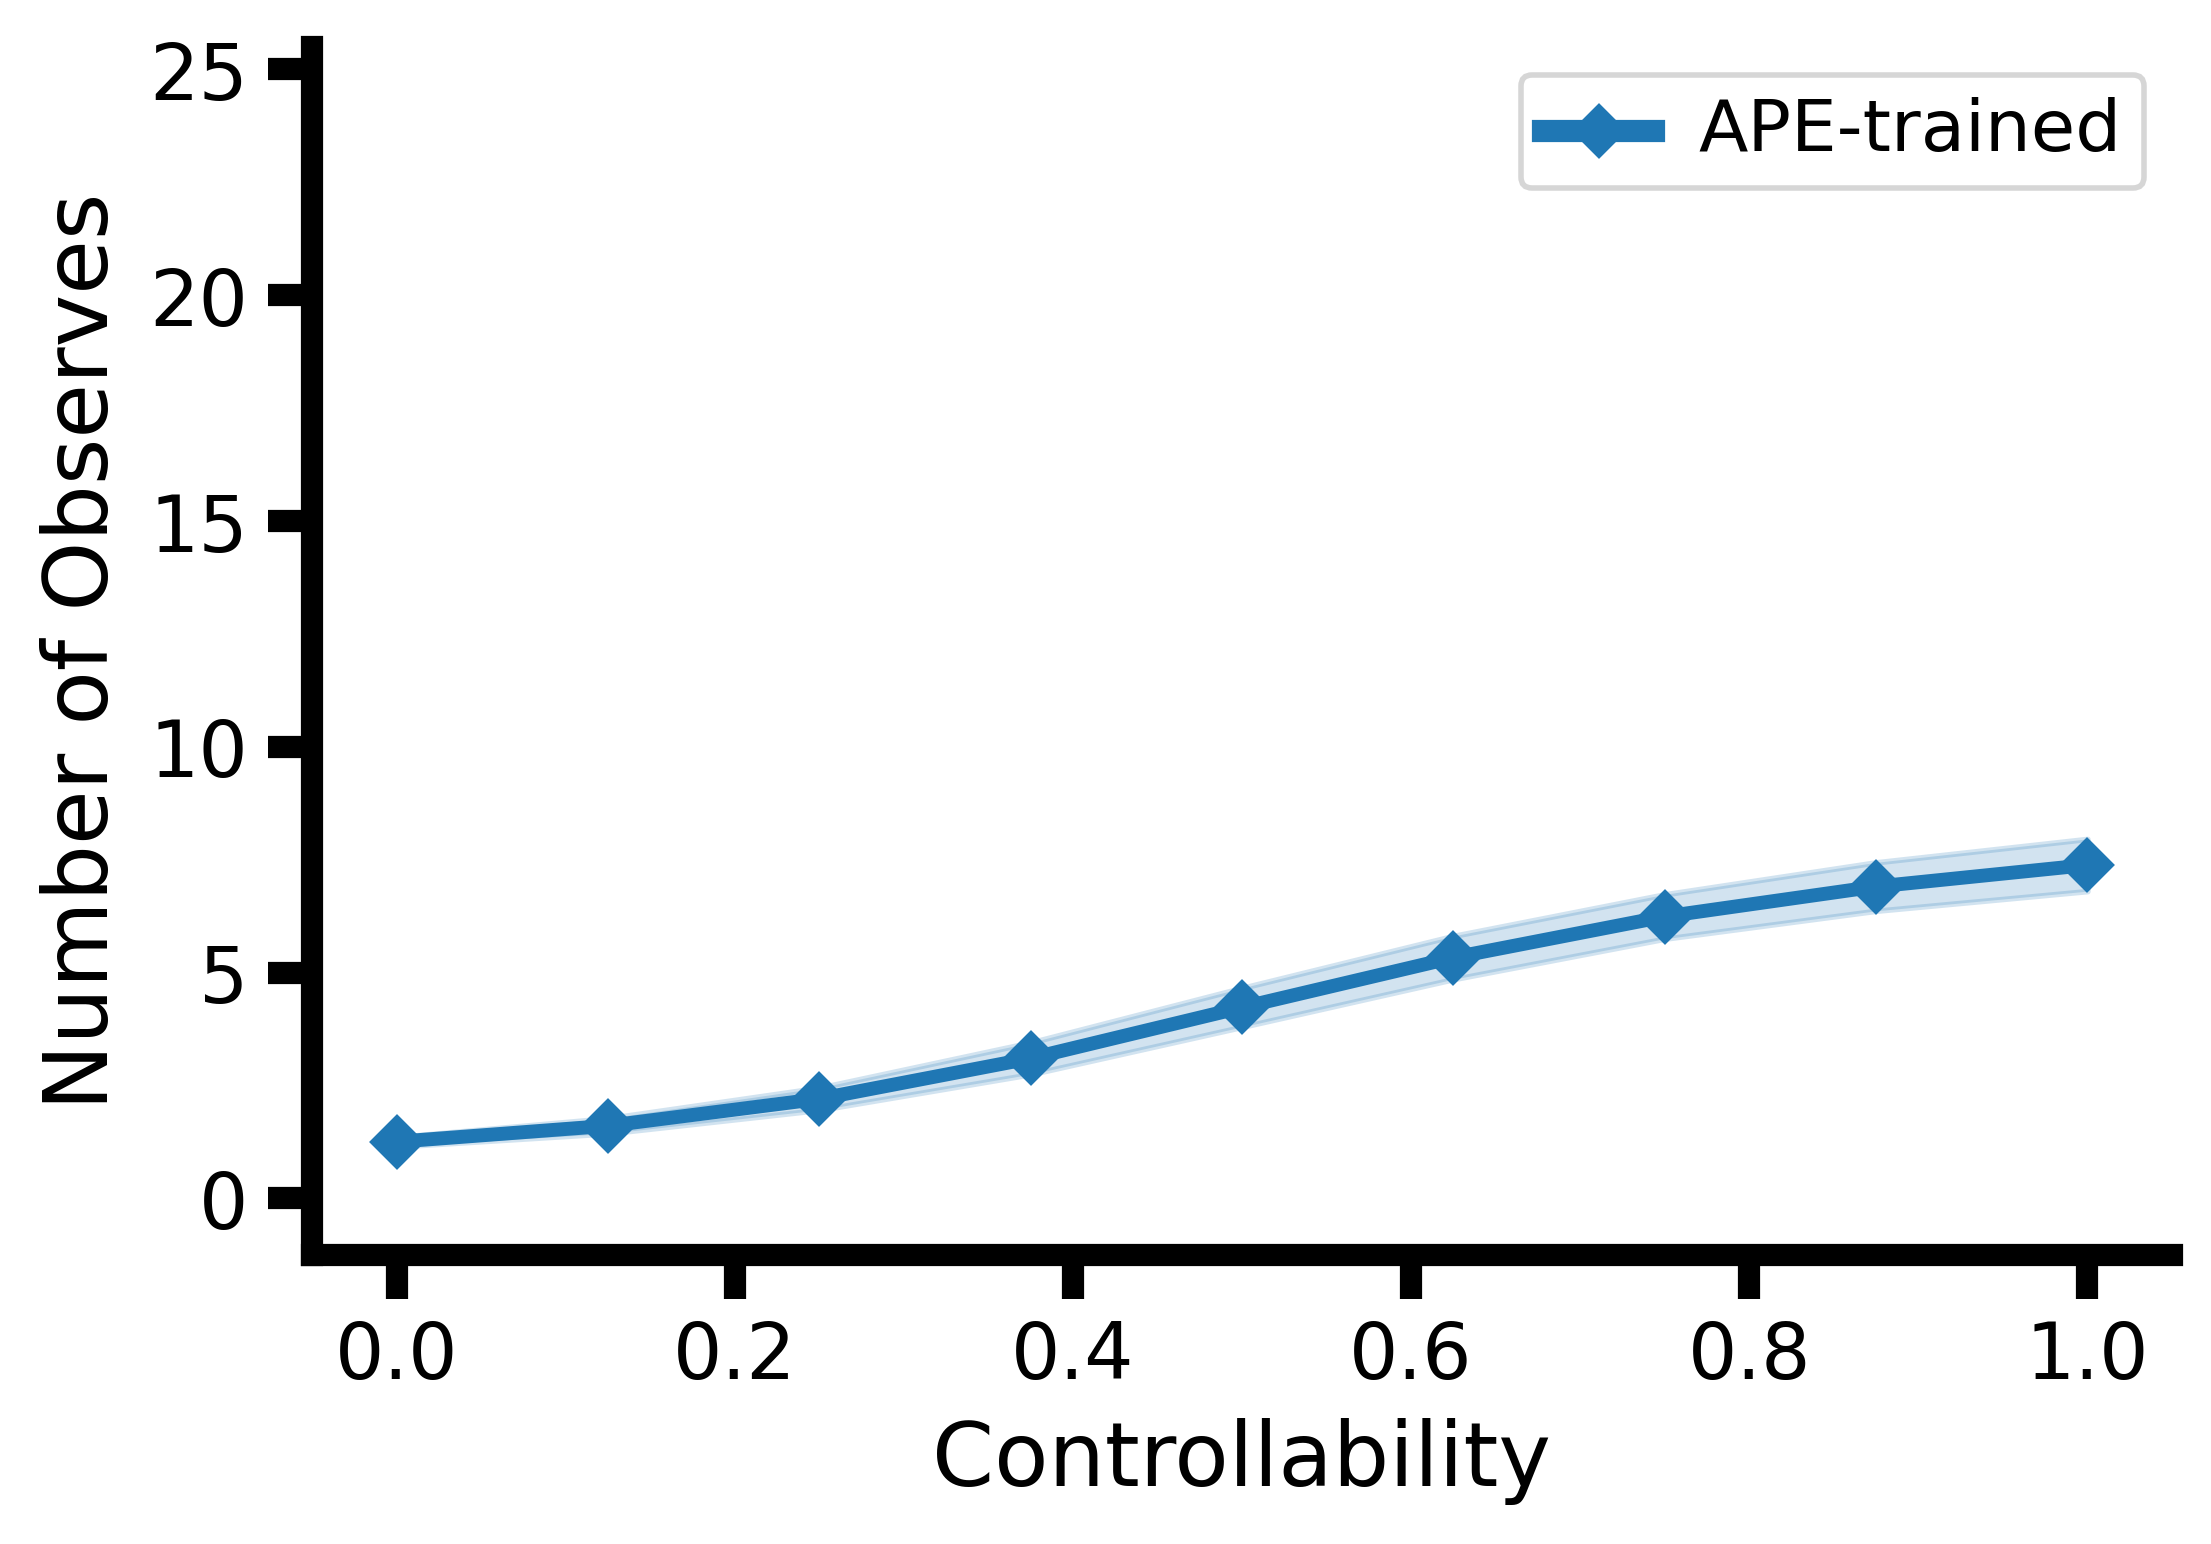

In [38]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(test_taus, list(reversed(counterss_peeks_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [39]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.svg'))

### No-APE Networks

In [40]:
from settings_ana import pepe_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_ana import pepe_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

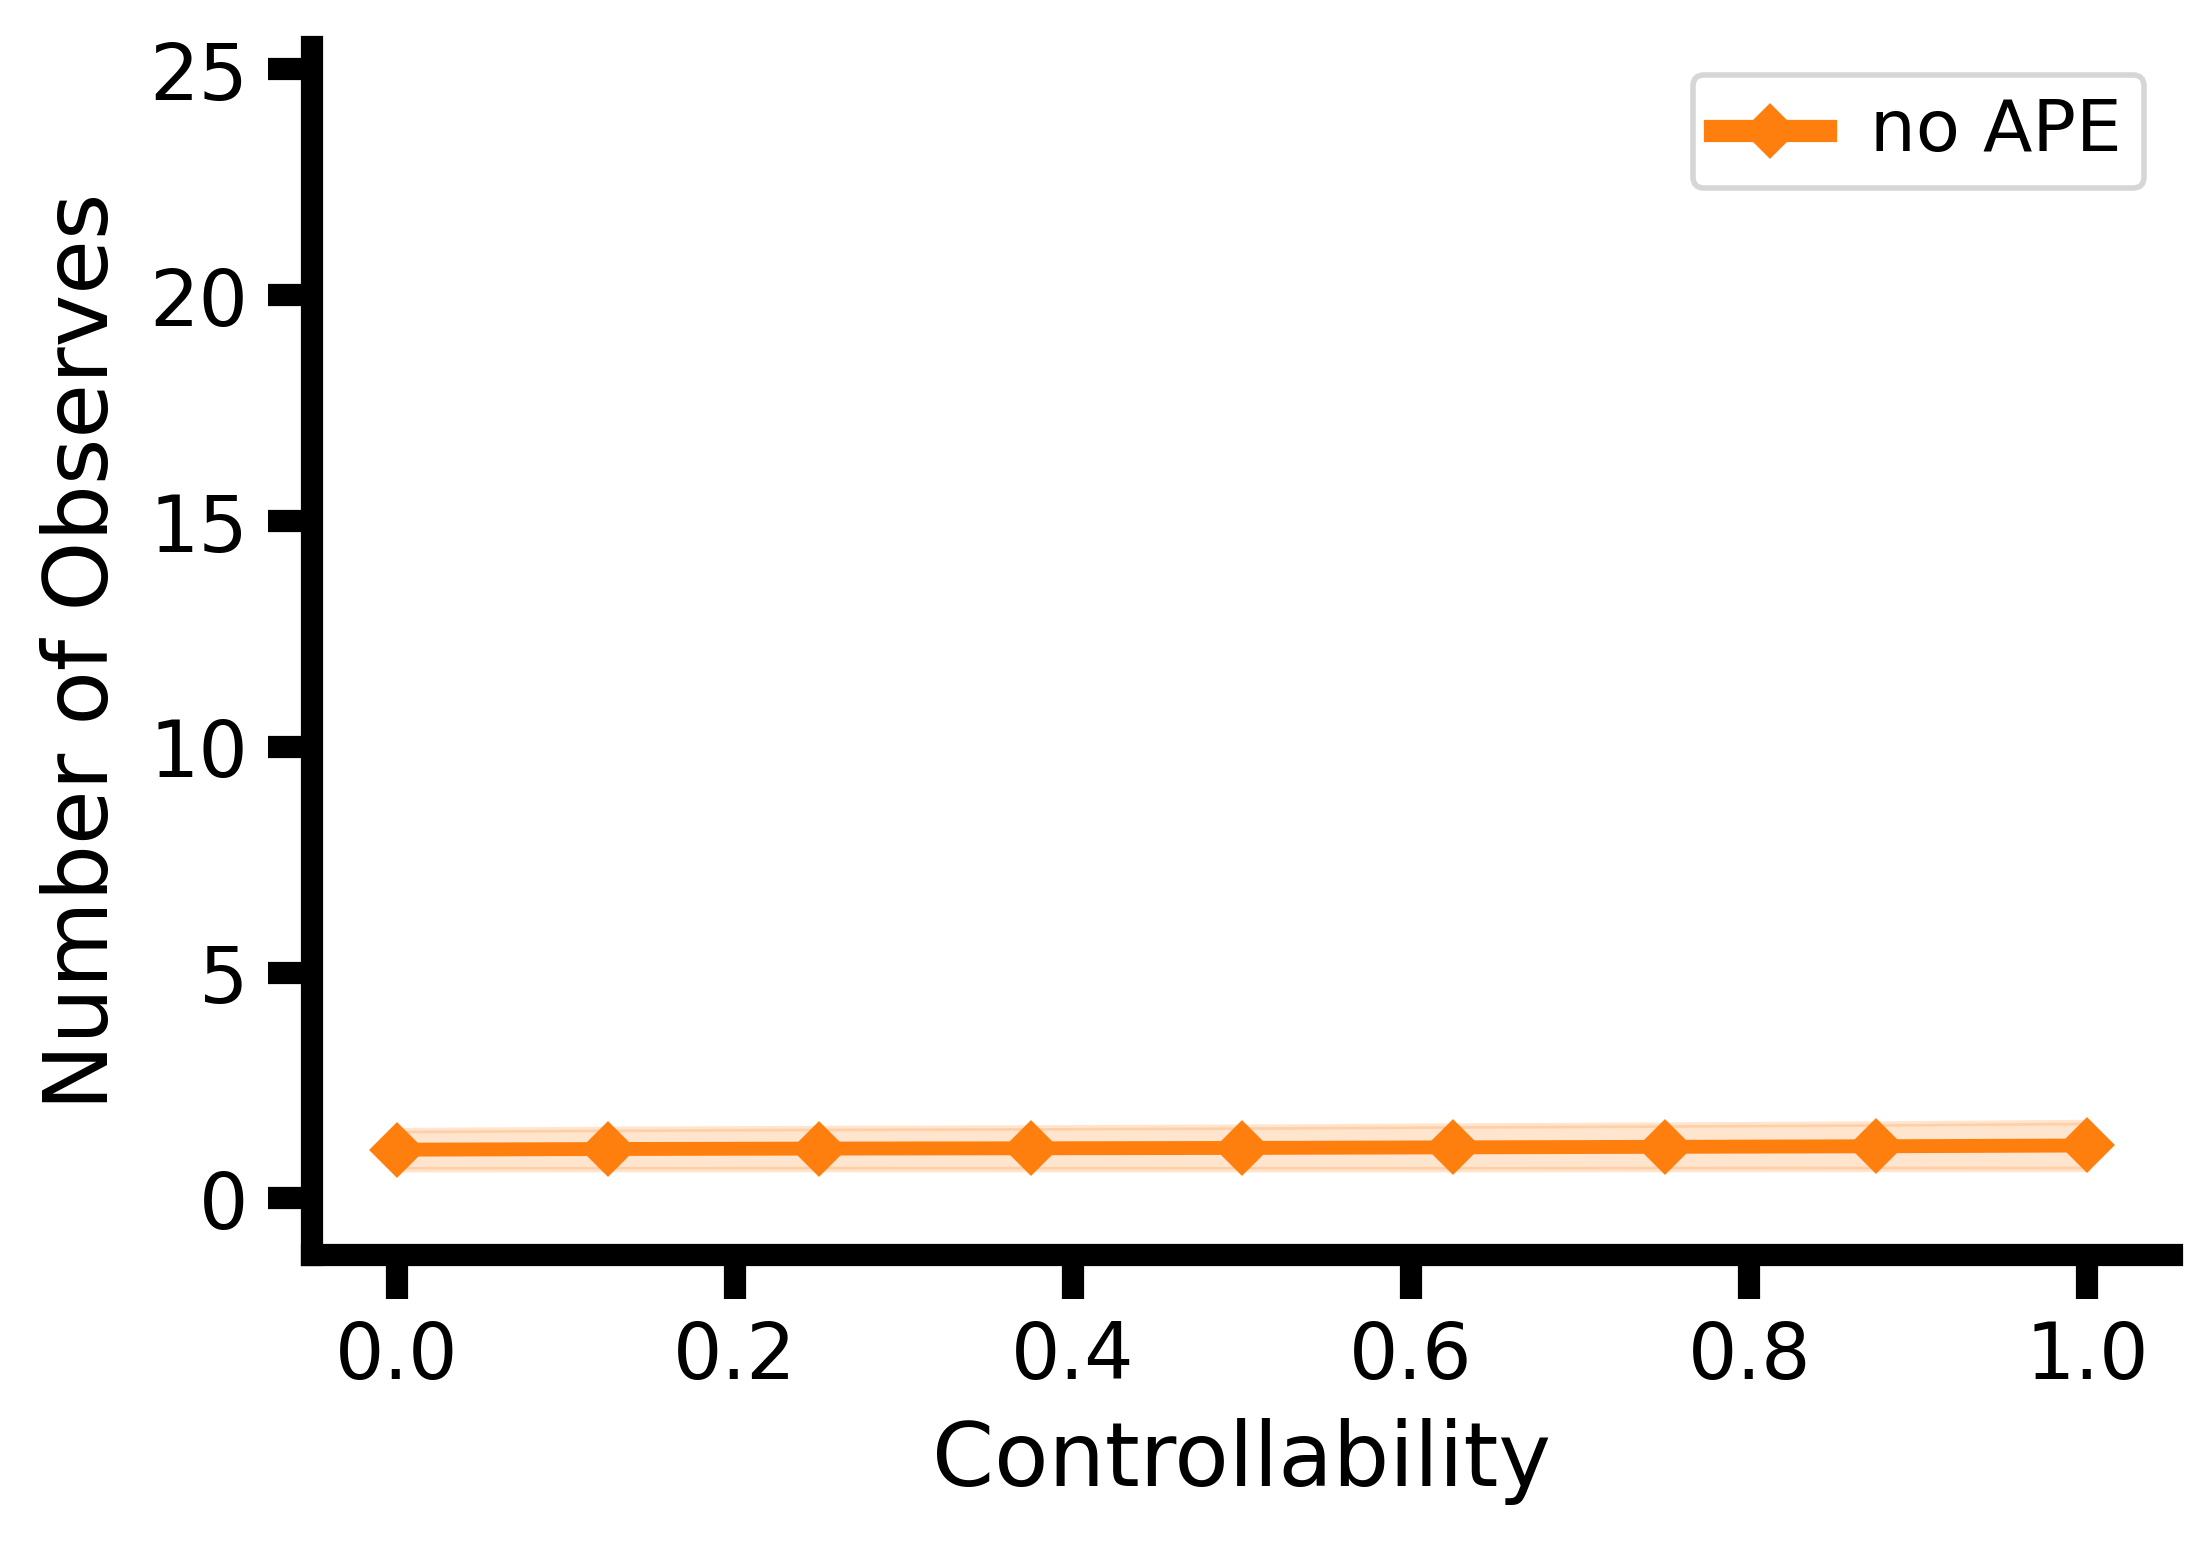

In [41]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(counterss_peeks_taus_control)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [42]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.svg'))

## Panel D: Across-Episode Rewards
### General Options

In [43]:
ylim= (-1, 49)

### Humans

In [44]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day2'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [45]:
n_trainA, n_testA = sort_train_test(df[~df['group']]['rewards_tallies'], df[~df['group']]['effs'], test_start[0])
n_trainB, n_testB = sort_train_test(df[df['group']]['rewards_tallies'], df[df['group']]['effs'], test_start[1])

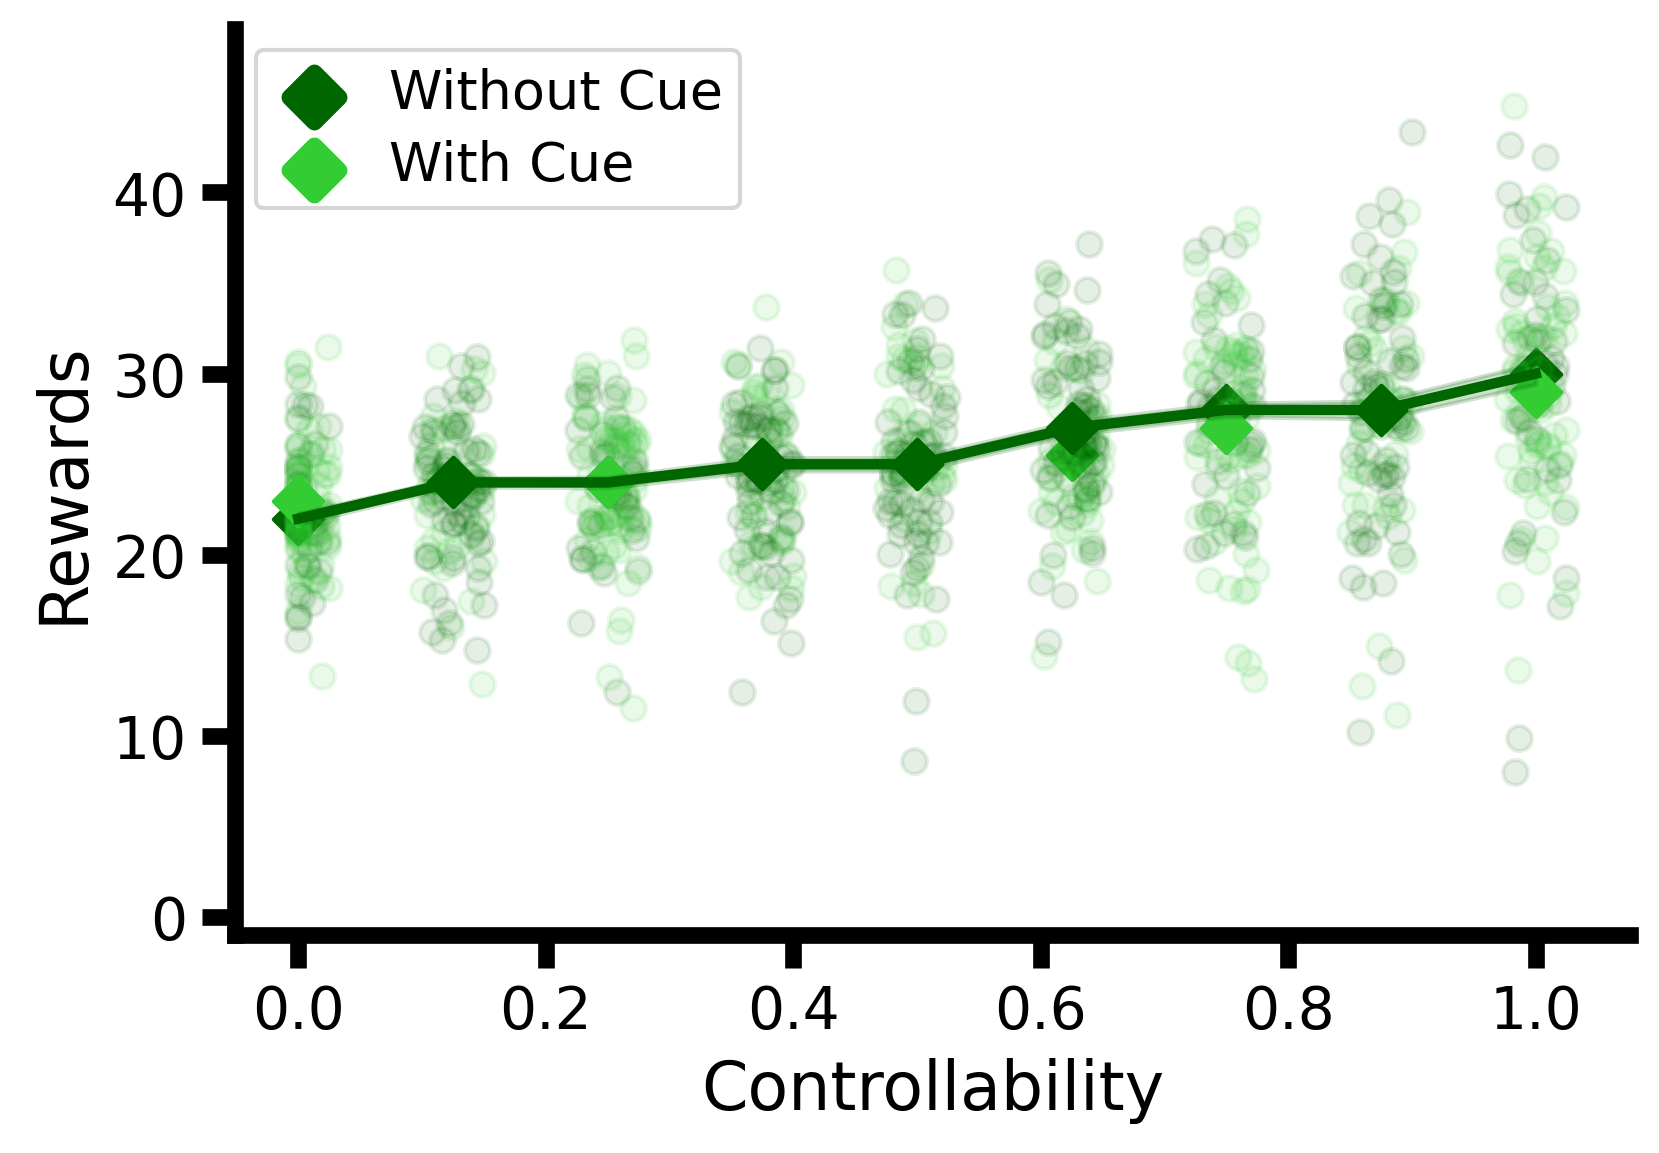

In [46]:
from human_plot_traj_analyses import plot_line_scatter_group

fig = plot_line_scatter_group((n_testA, n_testB), effs_test, (n_trainA, n_trainB), effs_train, ylabel='Rewards', ylim=ylim, xjitter=0.025, yjitter=1, median_over_mean=True,)

In [47]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.svg'))

#### Stats

In [48]:
selected_rewards_tallies = [n_testA[:,-1], n_testB[:,2], n_testA[:,0]]

In [49]:
## MEANS AND SEMS
for level, rewards in zip(plotted_levels, selected_rewards_tallies):
    print("Test Controllability ", level)
    print("Mean ", rewards.mean())
    print("StdErr ", rewards.std()/np.sqrt(rewards.shape[0]))
    print("N", rewards.shape[0])

Test Controllability  1
Mean  29.369565217391305
StdErr  1.0642669653730146
N 46
Test Controllability  0.5
Mean  24.661538461538463
StdErr  0.585940572173709
N 65
Test Controllability  0
Mean  22.47826086956522
StdErr  0.5187770358133812
N 46


In [50]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, selected_rewards_tallies)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(selected_rewards_tallies), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    0.5   2.1833 0.0899 -0.2587 4.6252  False
   0.0    1.0   6.8913    0.0  4.2486  9.534   True
   0.5    1.0    4.708    0.0  2.2661   7.15   True
---------------------------------------------------


In [51]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'rewards_tallies')
glm.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: rewards_tallies
No. Observations: 999     Method:             REML           
No. Groups:       111     Scale:              19.9434        
Min. group size:  9       Log-Likelihood:     -2948.6878     
Max. group size:  9       Converged:          Yes            
Mean group size:  9.0                                        
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          22.341    0.377 59.304 0.000 21.603 23.080
C(group_C)[T.True] -0.024    0.401 -0.061 0.951 -0.810  0.761
efficacy            6.549    0.438 14.960 0.000  5.691  7.407
Group Var           2.109    0.139                           
=============================================================

"""

### APE-trained Neural Networks

In [52]:
from settings_ana import pepe_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_ana import pepe_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

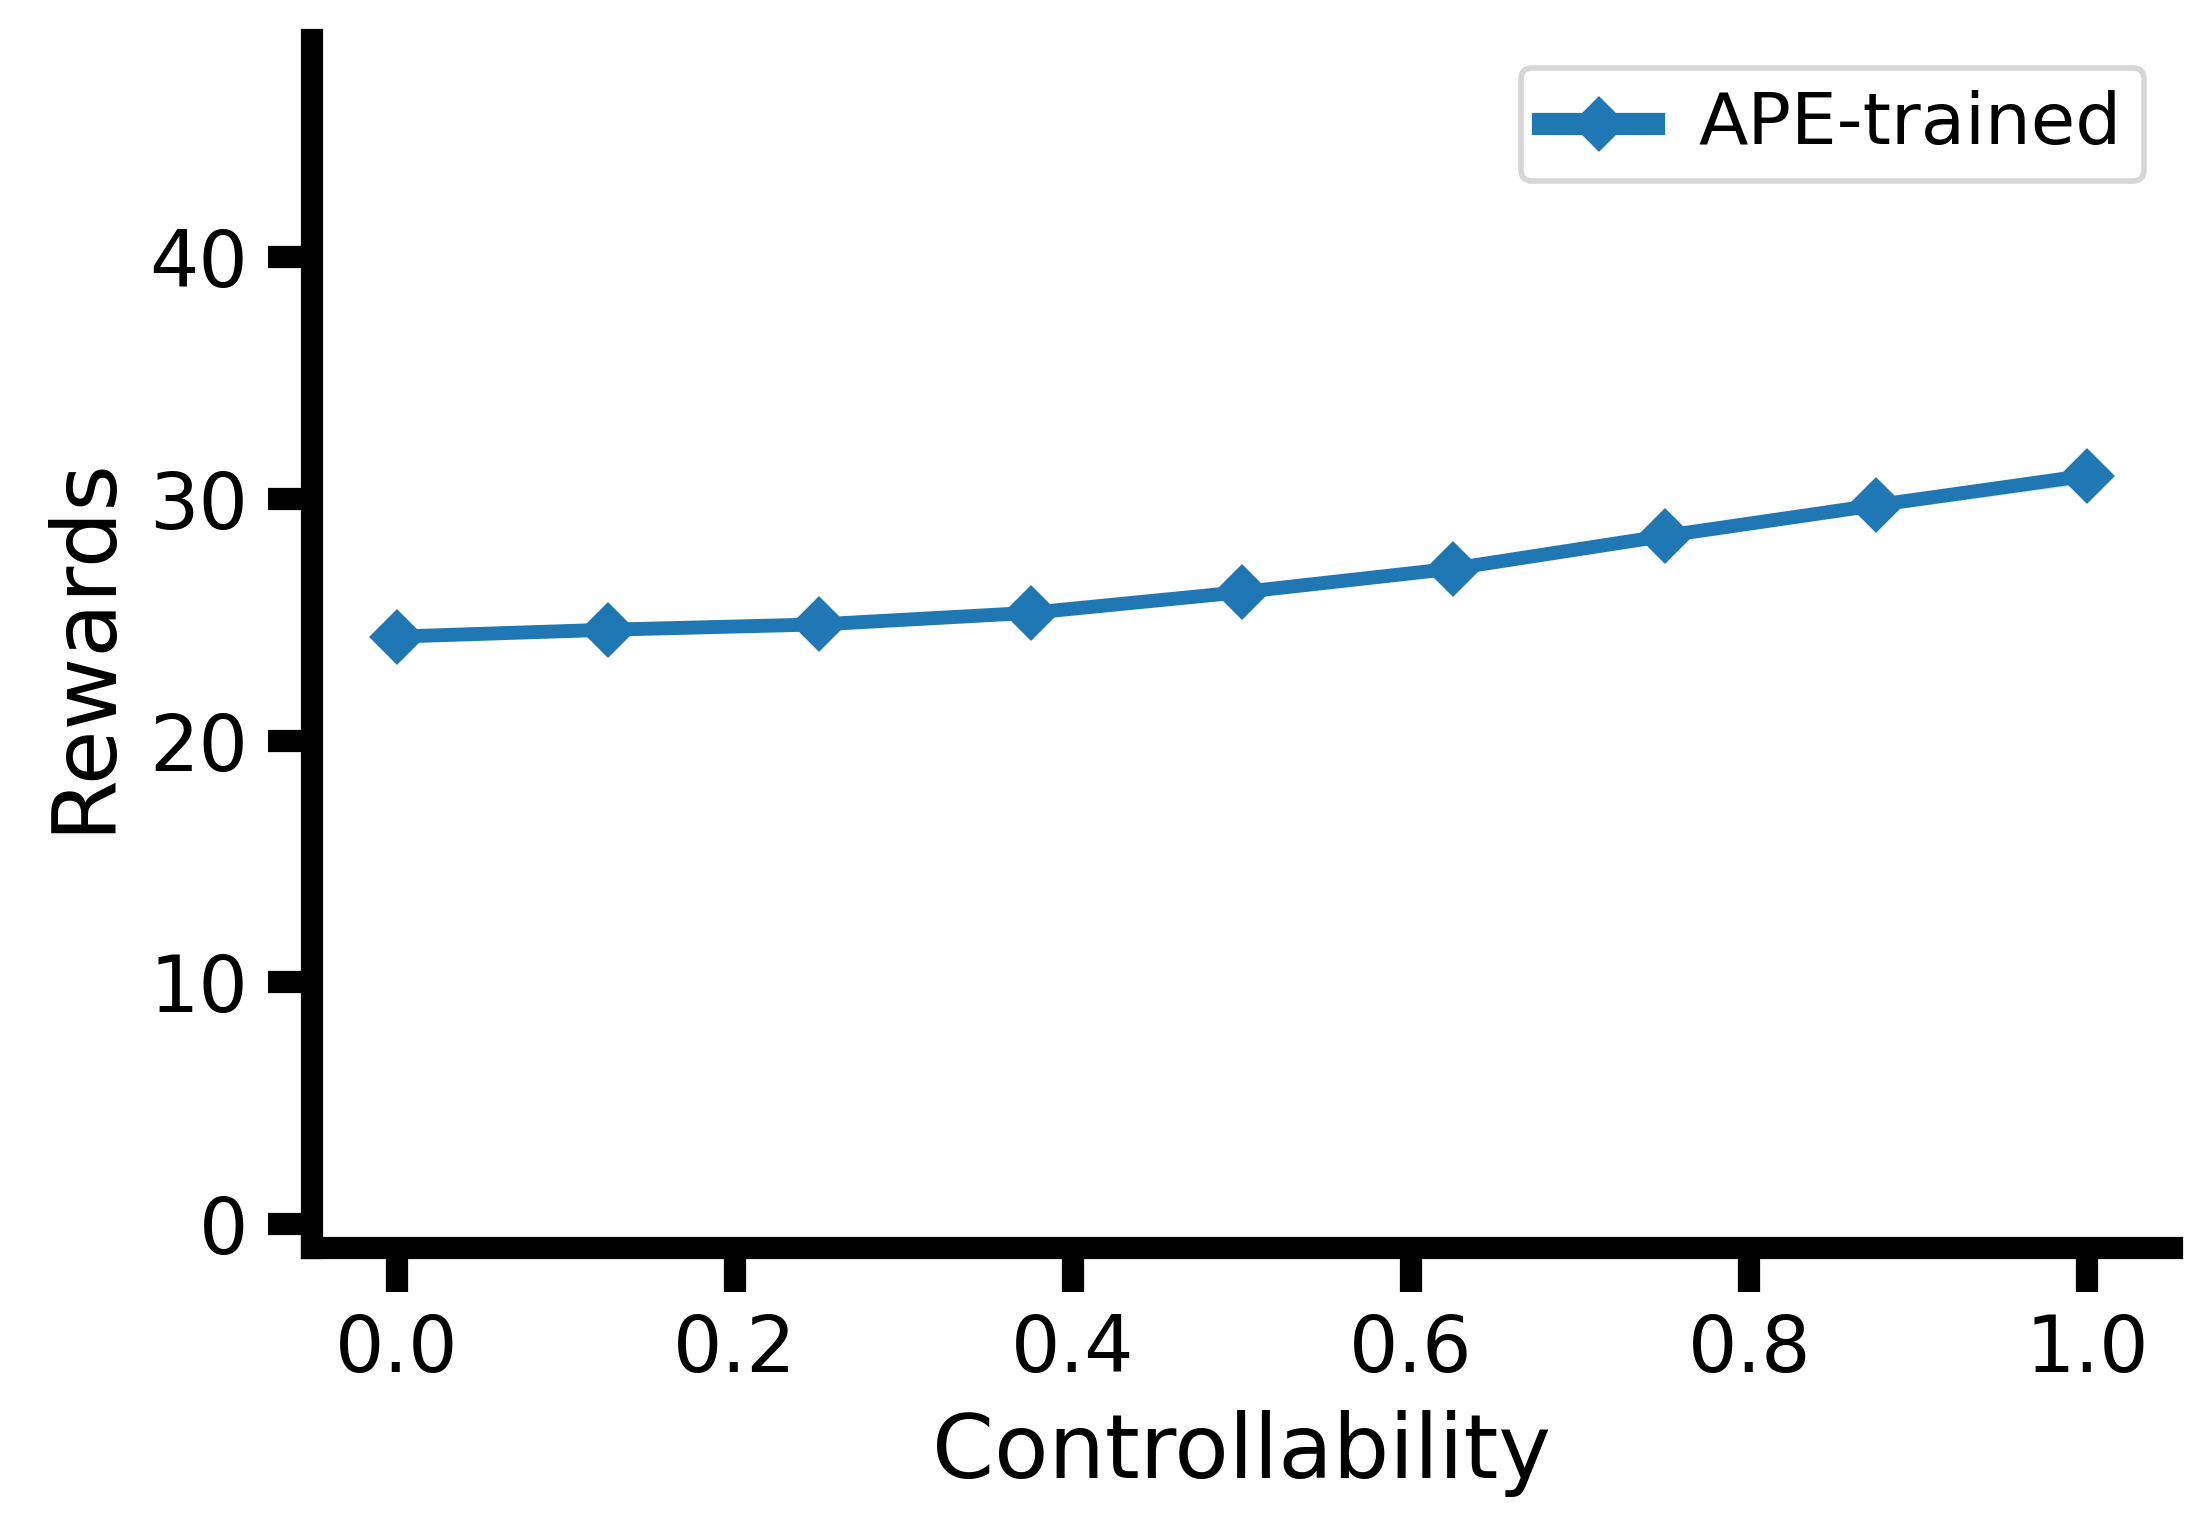

In [53]:
fig = plot_comparison_curves_several_runs(test_taus, list(reversed(rewss_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_exp='APE-trained', ylim=ylim, marker='D')

In [54]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.svg'))

### No-APE Networks

In [55]:
from settings_ana import pepe_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_ana import pepe_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'pepe', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

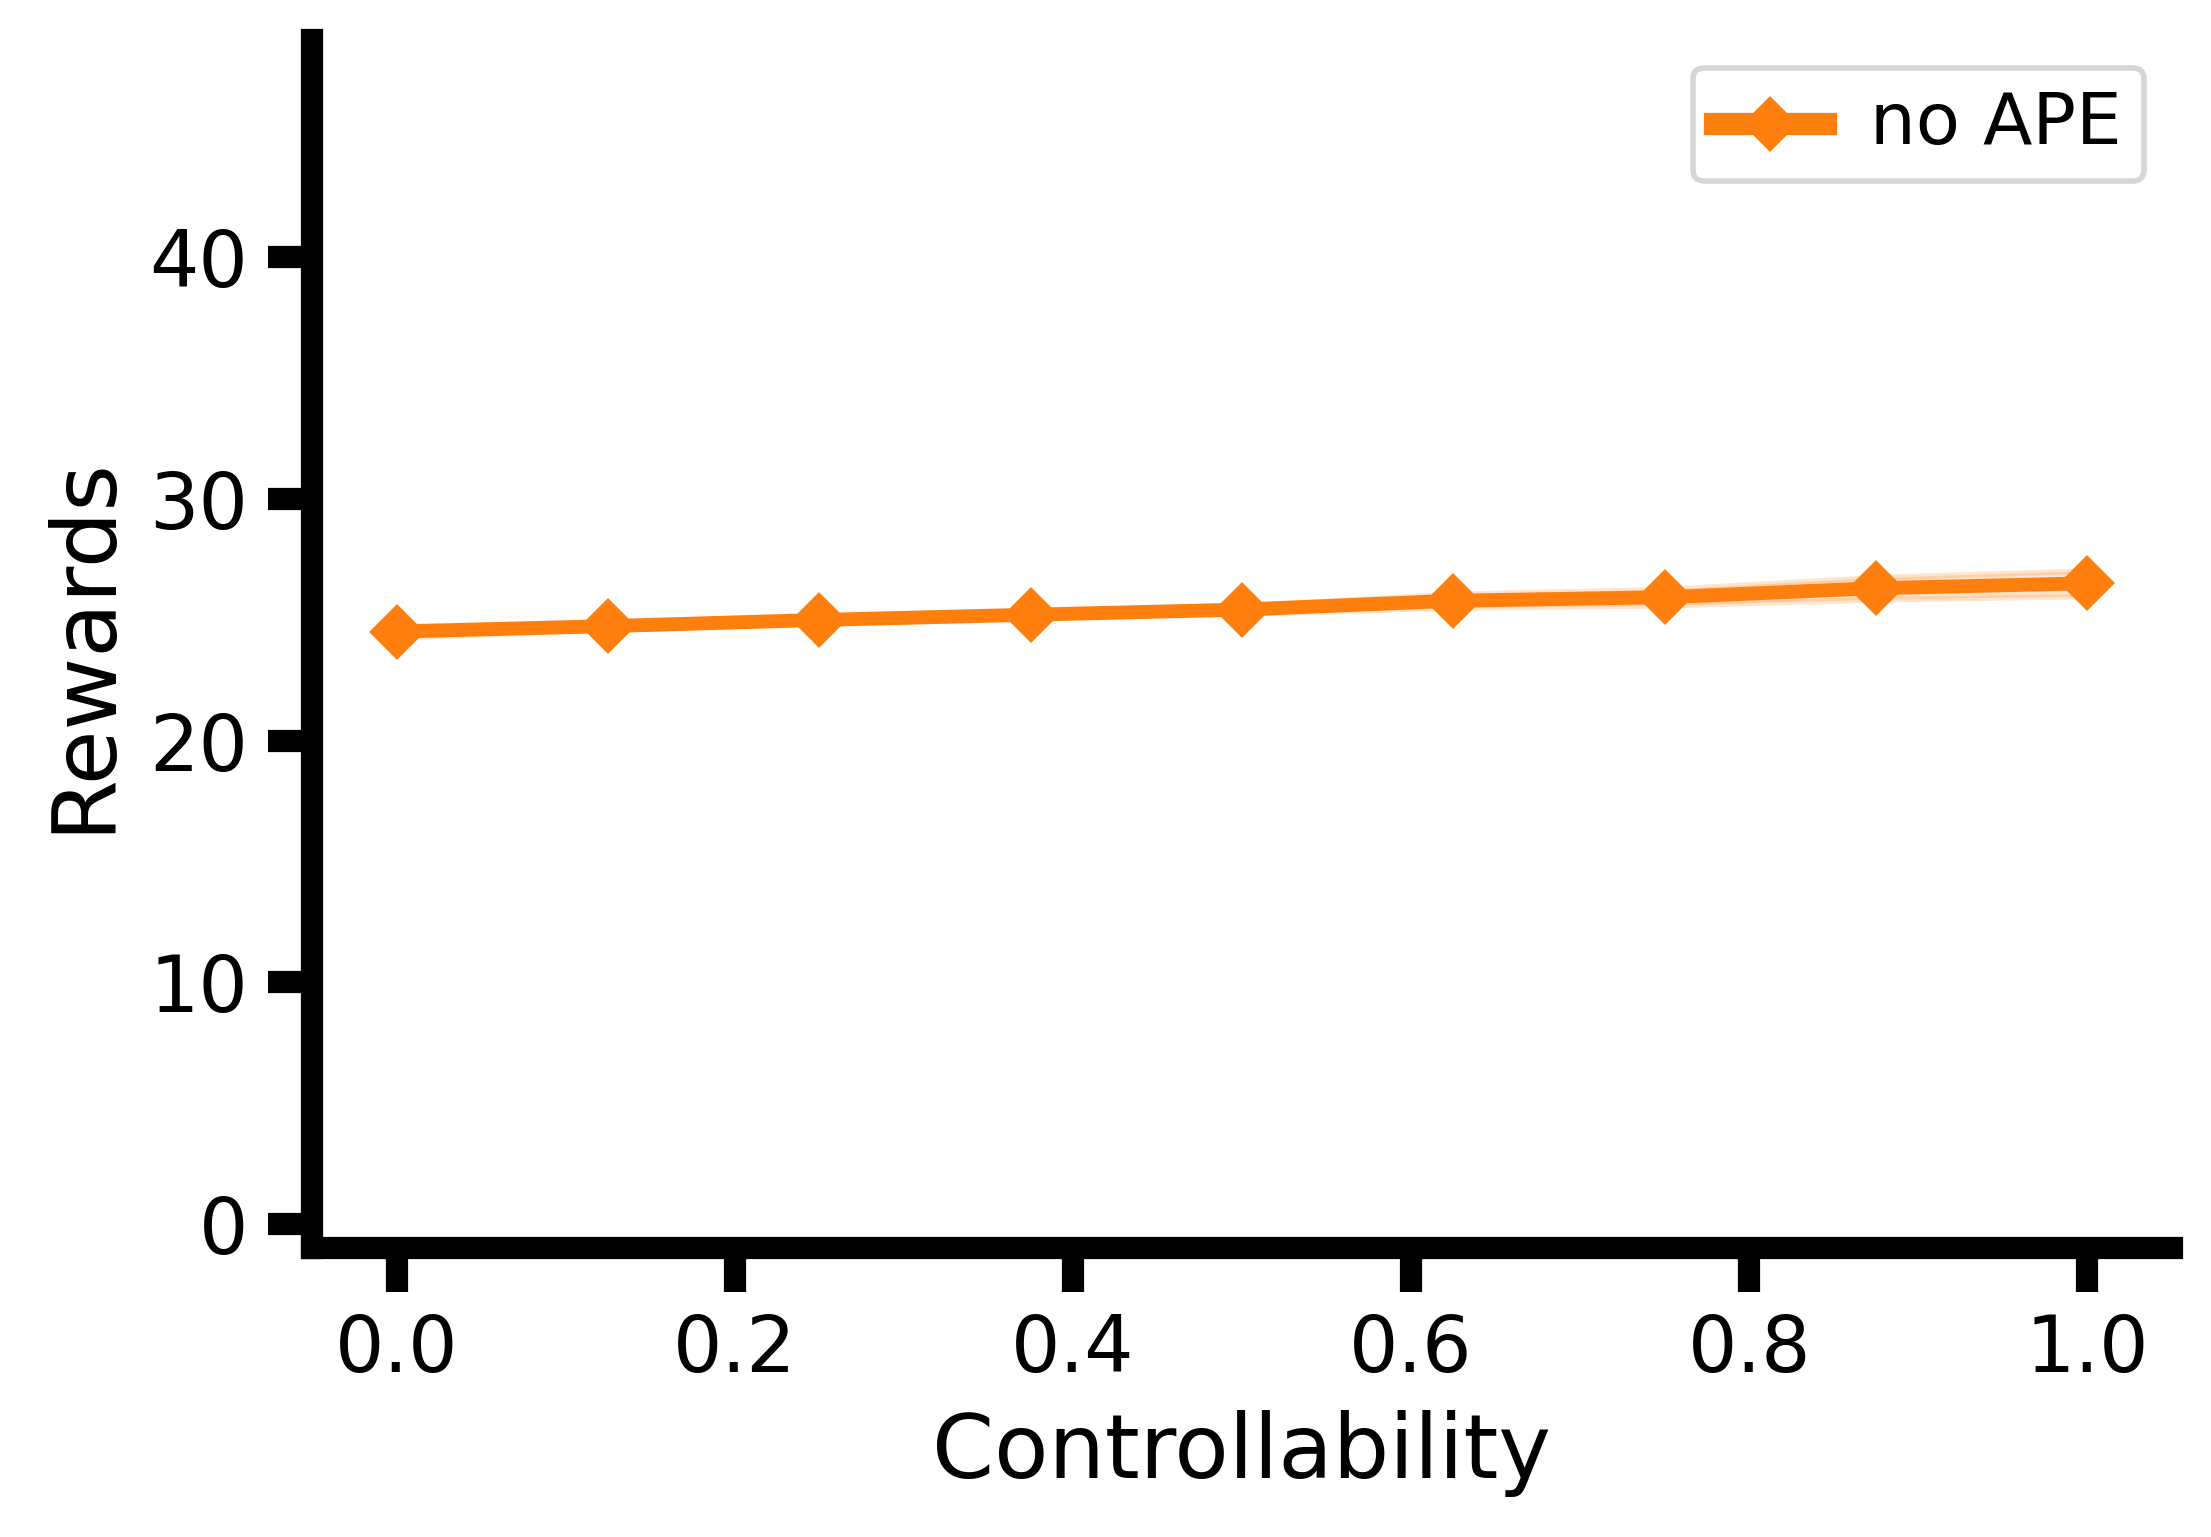

In [56]:
fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(rewss_taus_control)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_control='no APE', ylim=ylim, marker='D')

In [57]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.svg'))